This notebook adapts from the recent [SLICED's](https://www.notion.so/SLICED-Show-c7bd26356e3a42279e2dfbafb0480073) data science prediction challenge on predicting the prices of Airbnb listings in NYC. The analysis here is inspired by [Julia Silge](https://juliasilge.com/blog/nyc-airbnb/) and [David Robinson](https://github.com/dgrtwo/data-screencasts/blob/master/ml-practice/ep5.Rmd)

The evaluation metric for this competition is [Root Mean Squared Logarithmic Error](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError)
<center>
$ϵ = \sqrt{\frac{1}{n}\sum_{i=1}^n (log(p_i + 1) - log(a_i + 1))^2}$

In [ ]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
install.packages(c("tidymodels", "textrecipes", "baguette", "rlang", "scales", "stacks"))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#install.packages('broom')
install.packages('tidytext')
install.packages('repr')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
train_raw <- read_csv('train.csv')
test <- read_csv('test.csv')

Rows: 34226 Columns: 16

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): name, host_name, neighbourhood_group, neighbourhood, room_type
dbl  (10): id, host_id, latitude, longitude, price, minimum_nights, number_o...
date  (1): last_review


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 14669 Columns: 15

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): name, host_name, neighbourhood_group, neighbourhood, room_type
dbl  (9): id, host_id, latitude, longitude, minimum_nights, number_of_review...
date (1): last_review


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



## Exploratory Data Analysis

Firstly, look at the price distribution

In [ ]:
head(train_raw)

id      name                                    host_id  host_name
1 9901706 Cute big one bedroom                     1904415 Natalie  
2  299531 Feel like you never leave your home      1220404 Tom      
3 2461439 Pristine Lower East Side Sanctuary      12586492 Sausan   
4  127387 Luxe, Spacious 2BR 2BA Nr Trains           23276 Katharine
5  629315 1BD brownstone apt in Fort Greene!       2397437 Lauren   
6 4607923 LOVELY  LARGE SUNNY ROOM    Sunset Park  1113080 Audrey   
  neighbourhood_group neighbourhood   latitude longitude room_type       price
1 Manhattan           Upper West Side 40.77789 -73.97701 Entire home/apt 180  
2 Brooklyn            East New York   40.66795 -73.89232 Entire home/apt 100  
3 Manhattan           Lower East Side 40.72007 -73.98946 Entire home/apt 133  
4 Brooklyn            Gowanus         40.66862 -73.99260 Entire home/apt 260  
5 Brooklyn            Fort Greene     40.68935 -73.96950 Entire home/apt 120  
6 Brooklyn            Sunset Park     40.64722 -74.00475 Private room     55  
  minimum_nights number_of_reviews last_review reviews_per_month
1  1               0               <NA>          NA             
2  1             119               2019-06-30  1.39             
3 14             177               2019-05-03  2.82             
4 30               3               2014-08-04  0.03             
5  3              22               2015-10-28  0.27             
6  7              98               2019-05-22  1.75             
  calculated_host_listings_count availability_365
1 1                                0             
2 2                              289             
3 2                              221             
4 1                              316             
5 1                              189             
6 3                              312

In [ ]:
summary(train_raw)

       id               name              host_id           host_name        
 Min.   :    2539   Length:34226       Min.   :     2438   Length:34226      
 1st Qu.: 9509256   Class :character   1st Qu.:  7858210   Class :character  
 Median :19759863   Mode  :character   Median : 30878846   Mode  :character  
 Mean   :19084830                      Mean   : 67755715                     
 3rd Qu.:29219022                      3rd Qu.:107434423                     
 Max.   :36487245                      Max.   :274321313                     
                                                                             
 neighbourhood_group neighbourhood         latitude       longitude     
 Length:34226        Length:34226       Min.   :40.51   Min.   :-74.24  
 Class :character    Class :character   1st Qu.:40.69   1st Qu.:-73.98  
 Mode  :character    Mode  :character   Median :40.72   Median :-73.96  
                                        Mean   :40.73   Mean   :-73.95  
           

Selecting by n

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


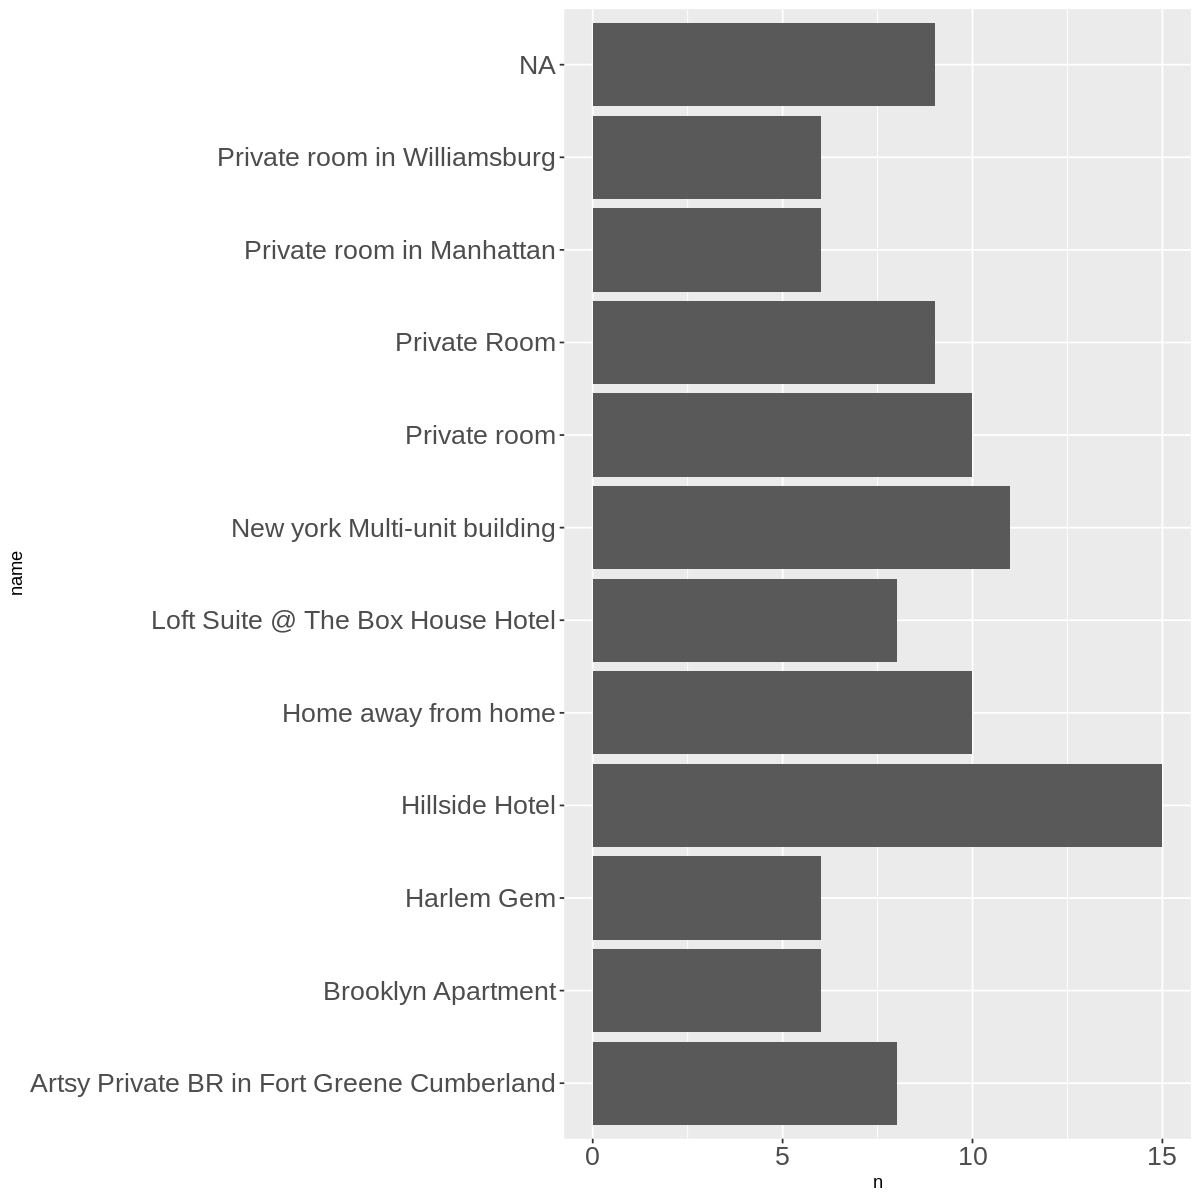

In [ ]:
library(repr)
options(repr.plot.width=10, repr.plot.height=10)

train_raw %>%
  count(name, sort = T) %>%
  arrange(desc(n)) %>%
  top_n(10) %>%
  ggplot(aes(x = n, y = name)) + 
  geom_histogram(stat='identity')+
  theme(axis.text = element_text(size=16))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



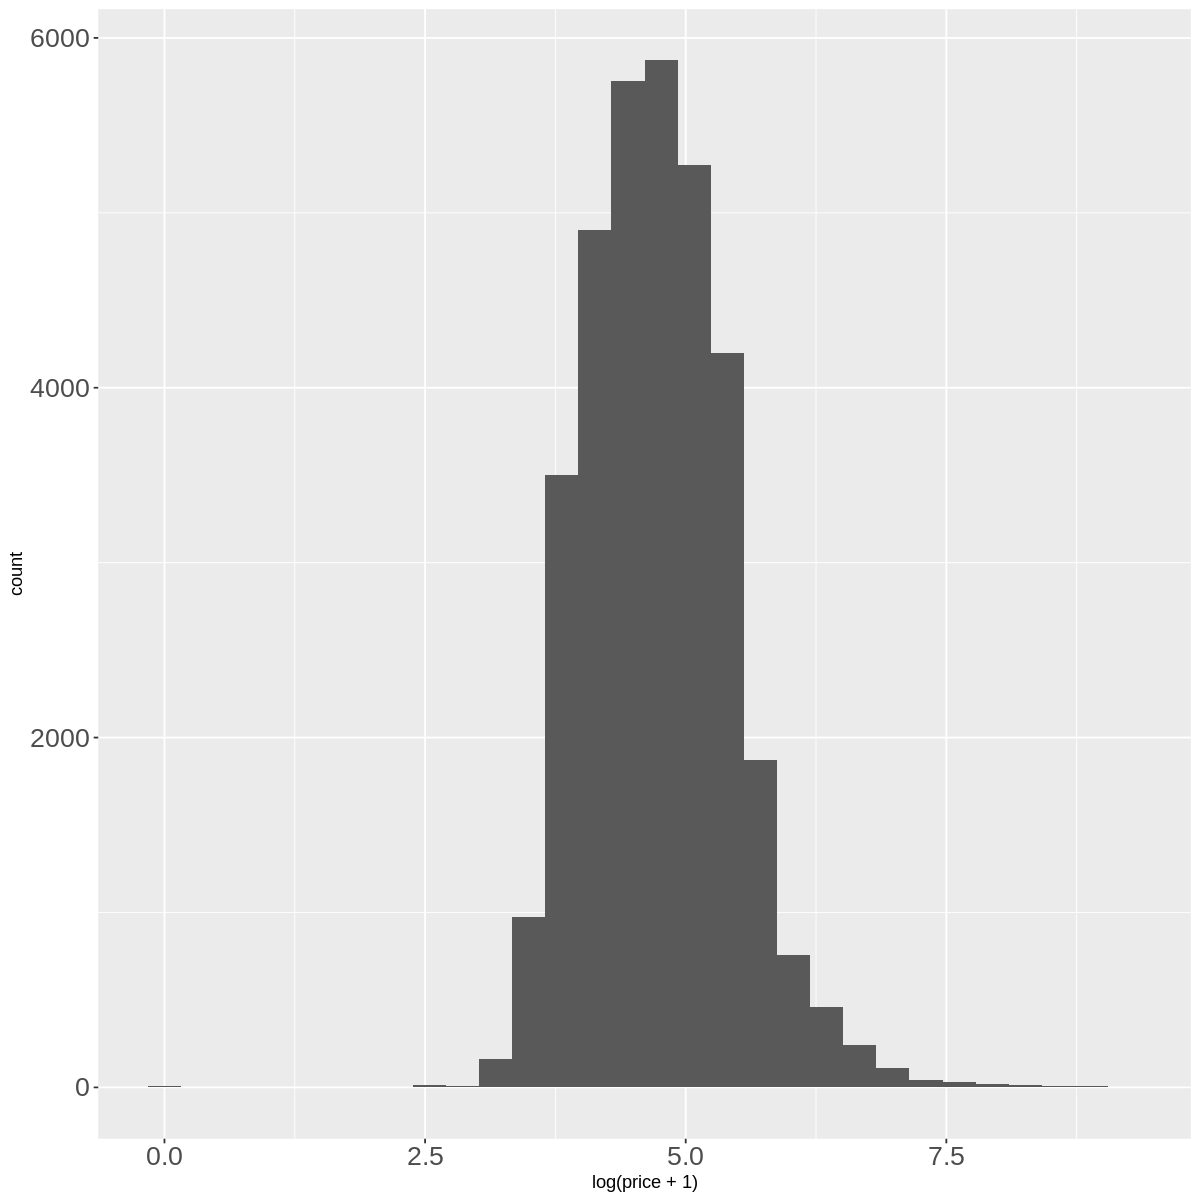

In [ ]:
train_raw %>%
  ggplot(aes(log(price + 1))) + 
  geom_histogram() +
  theme(axis.text = element_text(size=16))

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 8 rows containing non-finite values (stat_bin).”


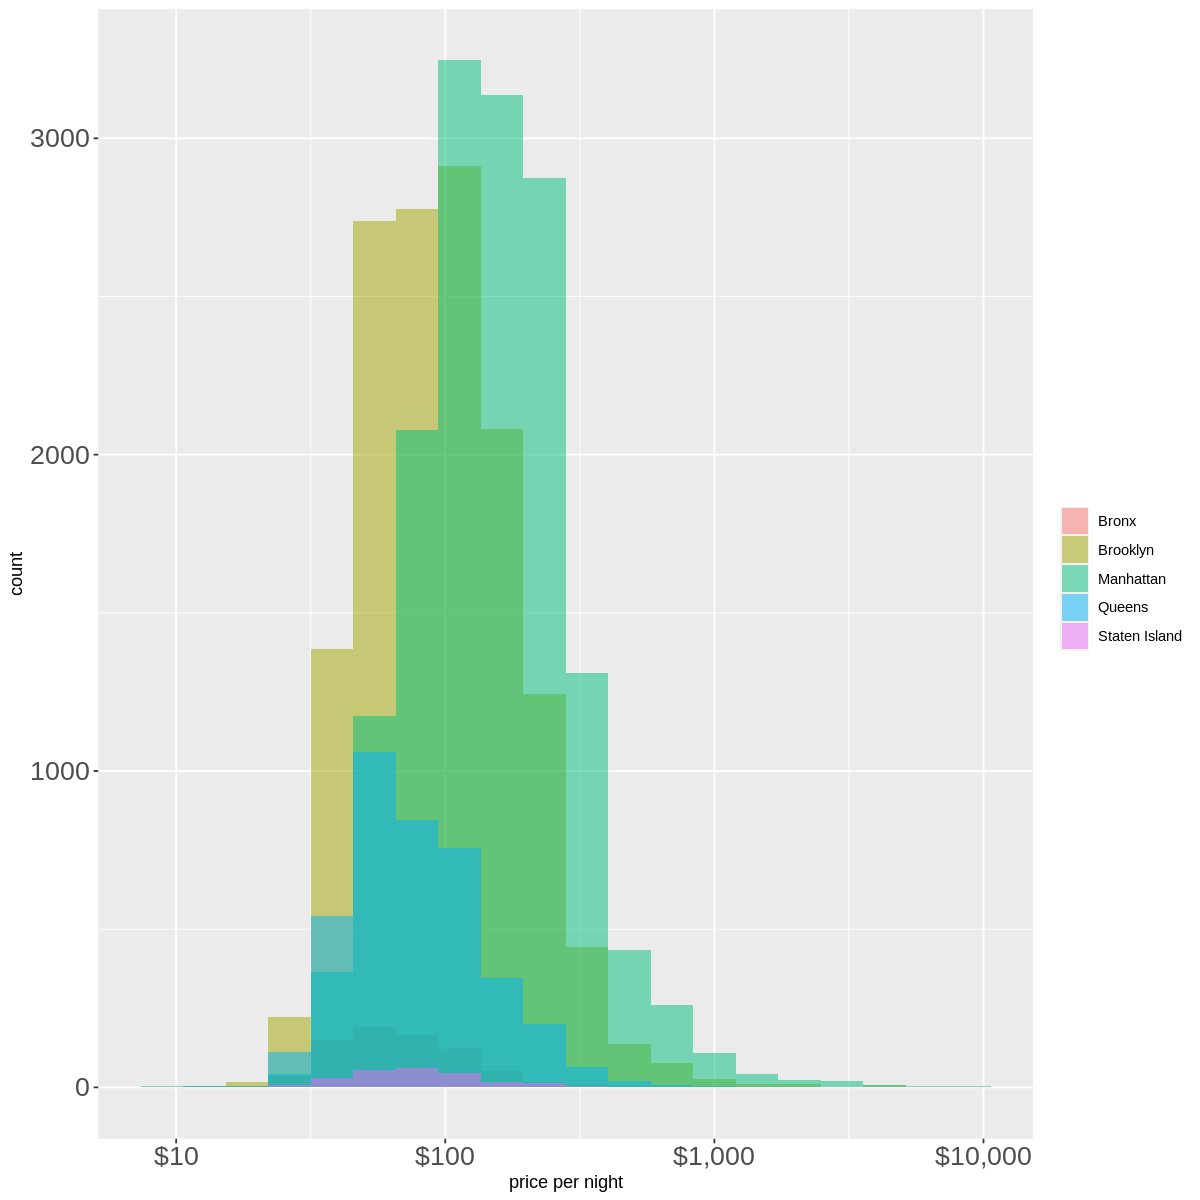

In [ ]:
train_raw %>%
  ggplot(aes(price, fill=neighbourhood_group)) +
  geom_histogram(position = 'identity', alpha=0.5, bins=20) +
  scale_x_log10(labels = scales::dollar_format()) +
  labs(fill = NULL, x = 'price per night') +
  theme(axis.text = element_text(size=16))

`price` seems to skew a lot as prices often are. We may need to some scaling later on for our model.

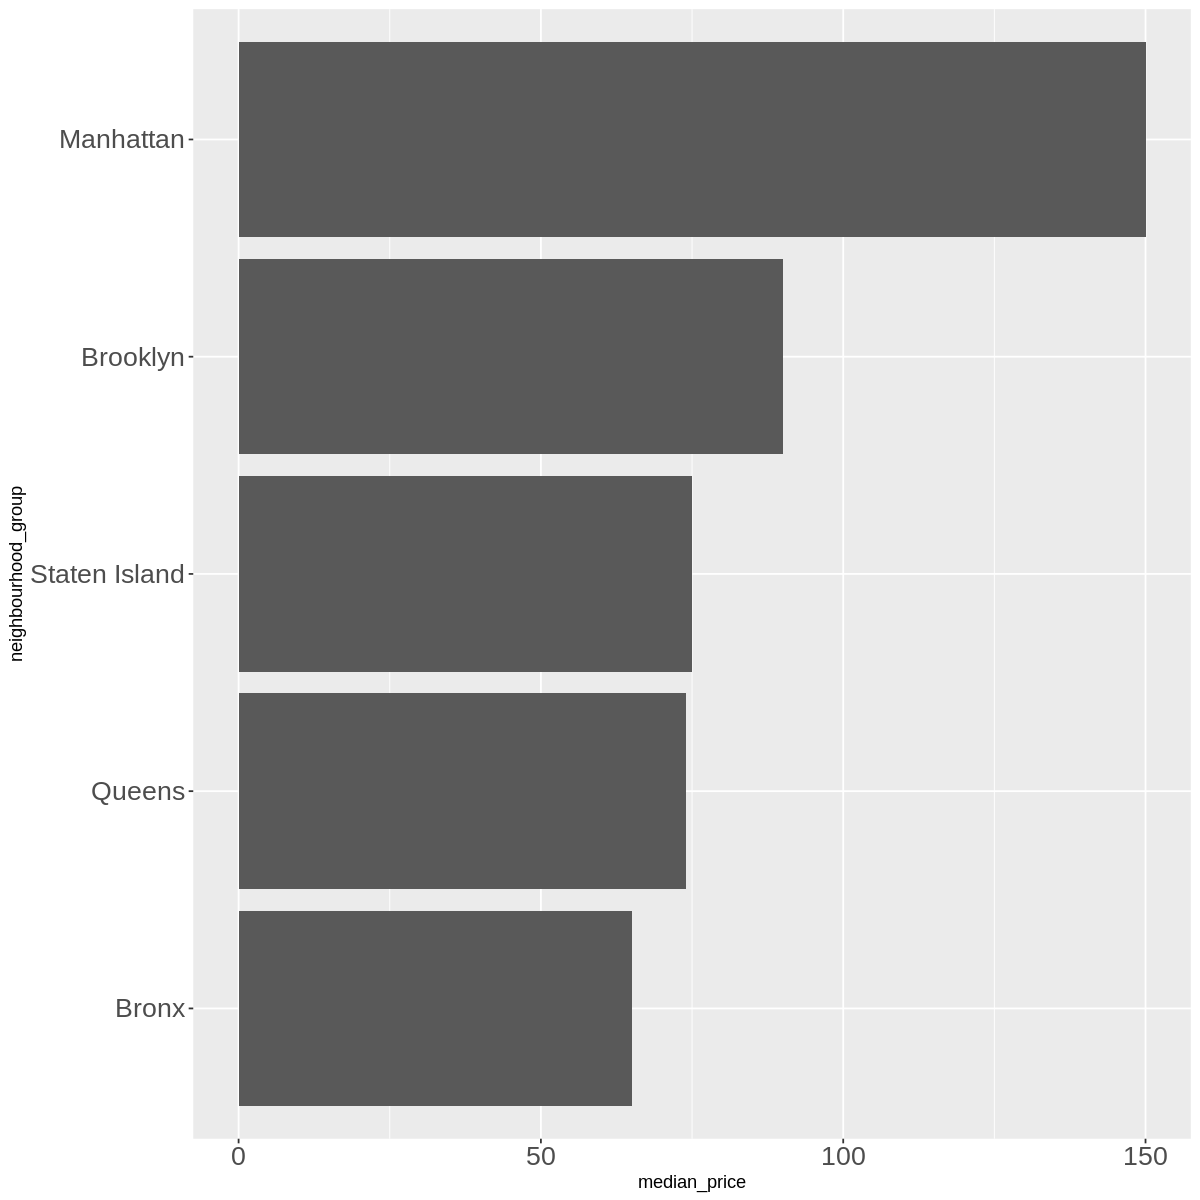

In [ ]:
# get mean and median price
summarize_prices <- function(tbl) {
  tbl %>%
    summarize(avg_price = exp(mean(price)) - 1,
              median_price = exp(median(price)) - 1,
              n = n()) %>%
    arrange(desc(n))
}

train_raw %>%
  mutate(price = log(price + 1)) %>%
  group_by(neighbourhood_group) %>%
  summarize_prices() %>%
  mutate(neighbourhood_group = fct_reorder(neighbourhood_group, median_price)) %>%
  ggplot(aes(median_price, neighbourhood_group)) +
  geom_col()+
  theme(axis.text = element_text(size=16))

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 8 rows containing non-finite values (stat_boxplot).”


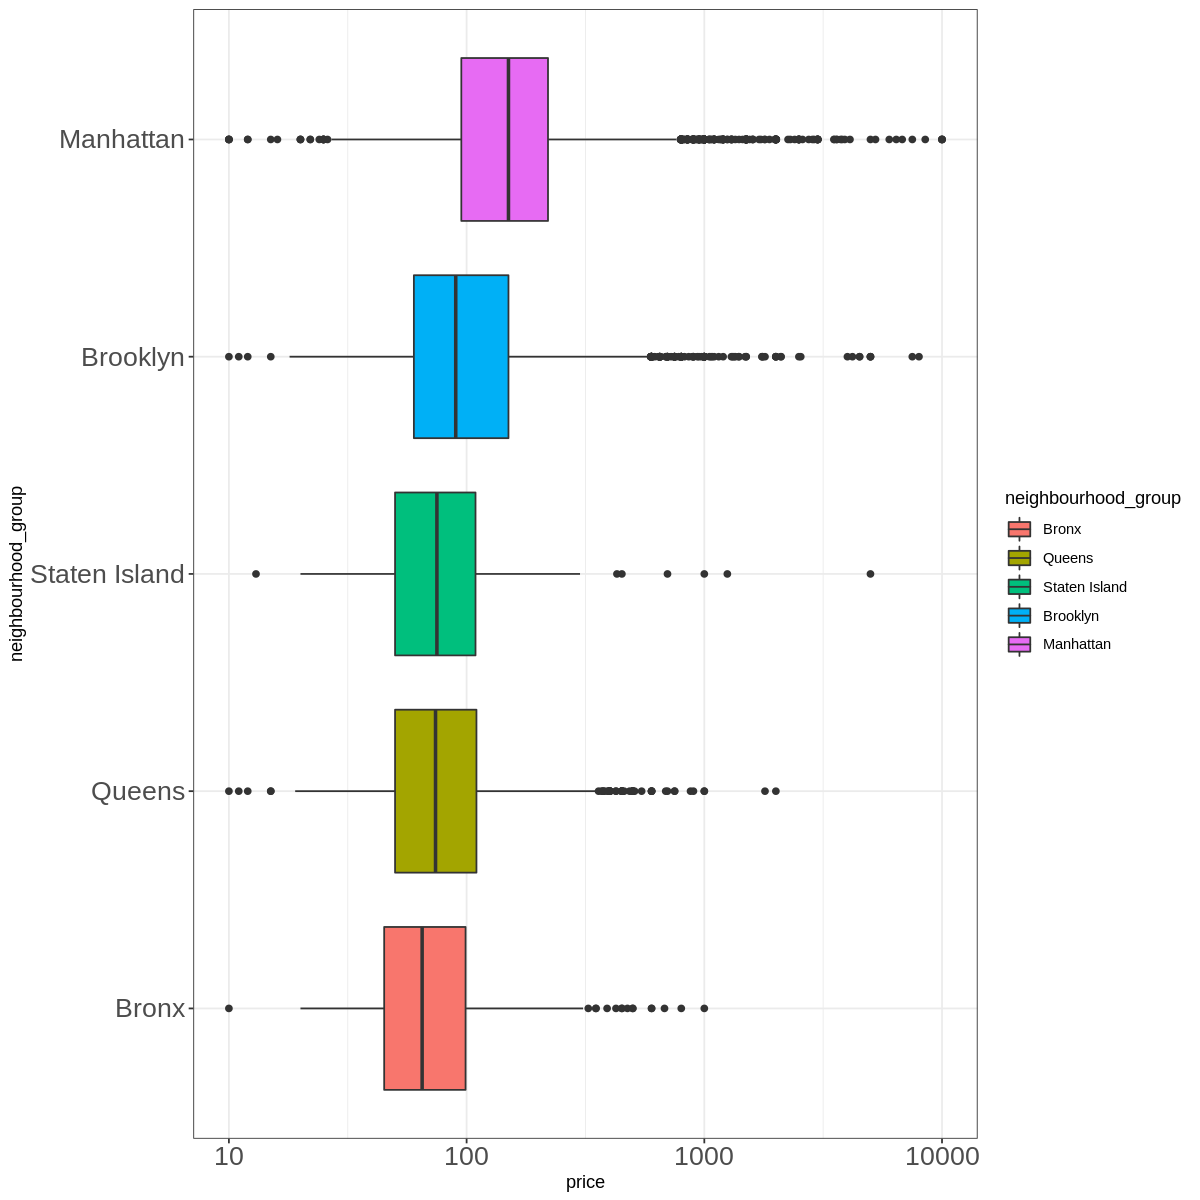

In [ ]:
train_raw %>%
  mutate(neighbourhood_group = fct_reorder(neighbourhood_group, price)) %>%
  ggplot(aes(price, neighbourhood_group, fill = neighbourhood_group)) +
  geom_boxplot() +
  scale_x_log10() + theme_bw()+
  theme(axis.text = element_text(size=16))

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 8 rows containing non-finite values (stat_boxplot).”


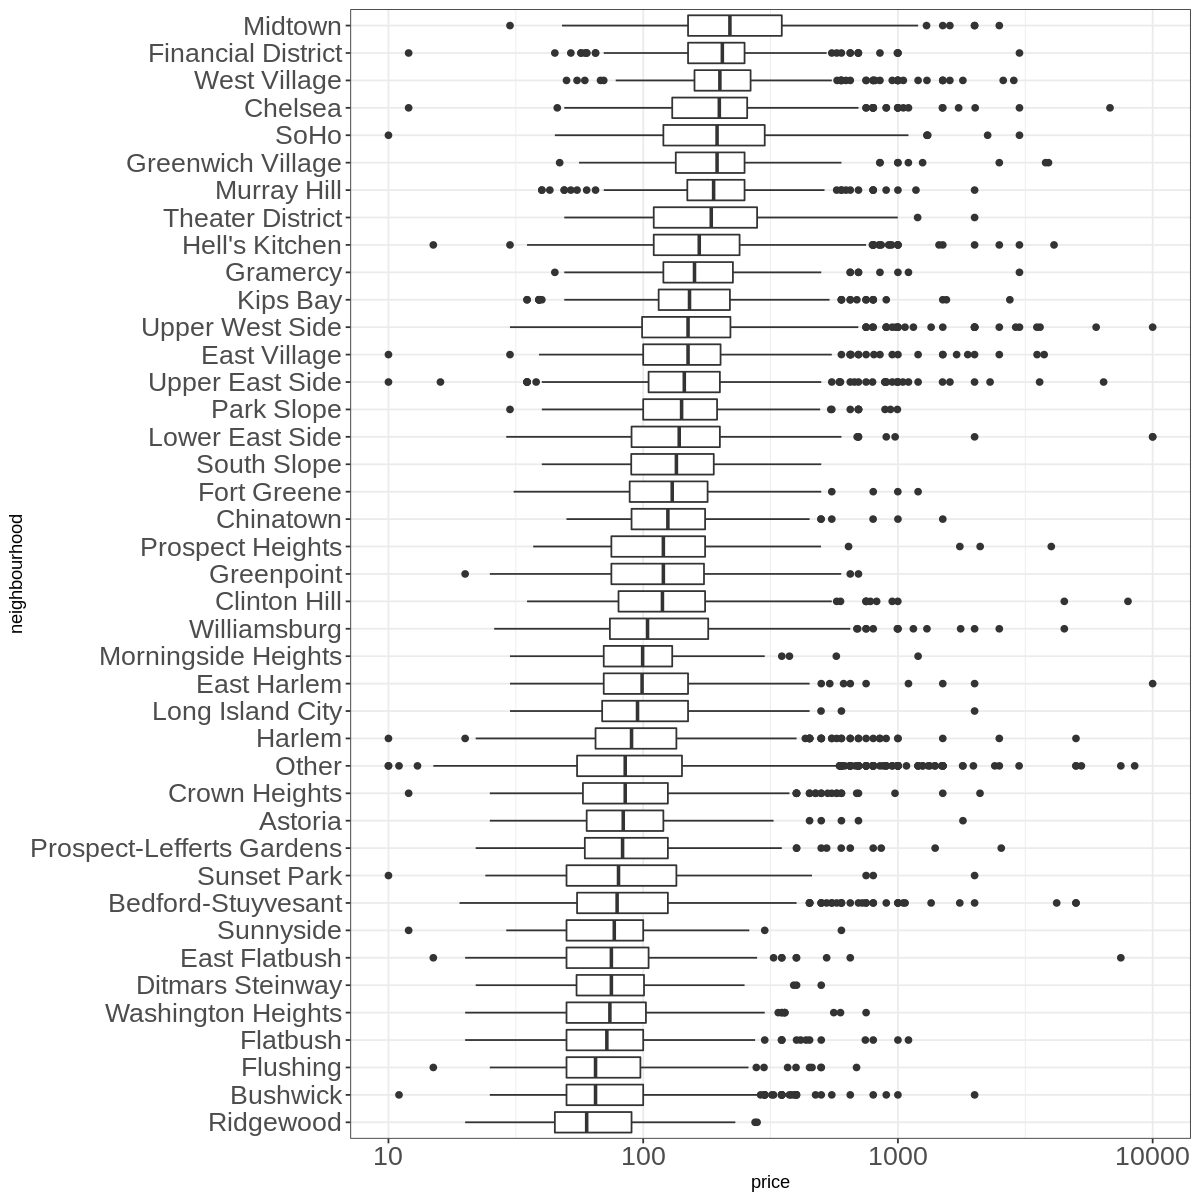

In [ ]:
train_raw %>%
  mutate(neighbourhood = fct_lump(neighbourhood, 40),
         neighbourhood = fct_reorder(neighbourhood, price)) %>%
  ggplot(aes(price, neighbourhood)) +
  geom_boxplot() +
  scale_x_log10() + theme_bw()+
  theme(axis.text = element_text(size=16))

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 8 rows containing non-finite values (stat_boxplot).”


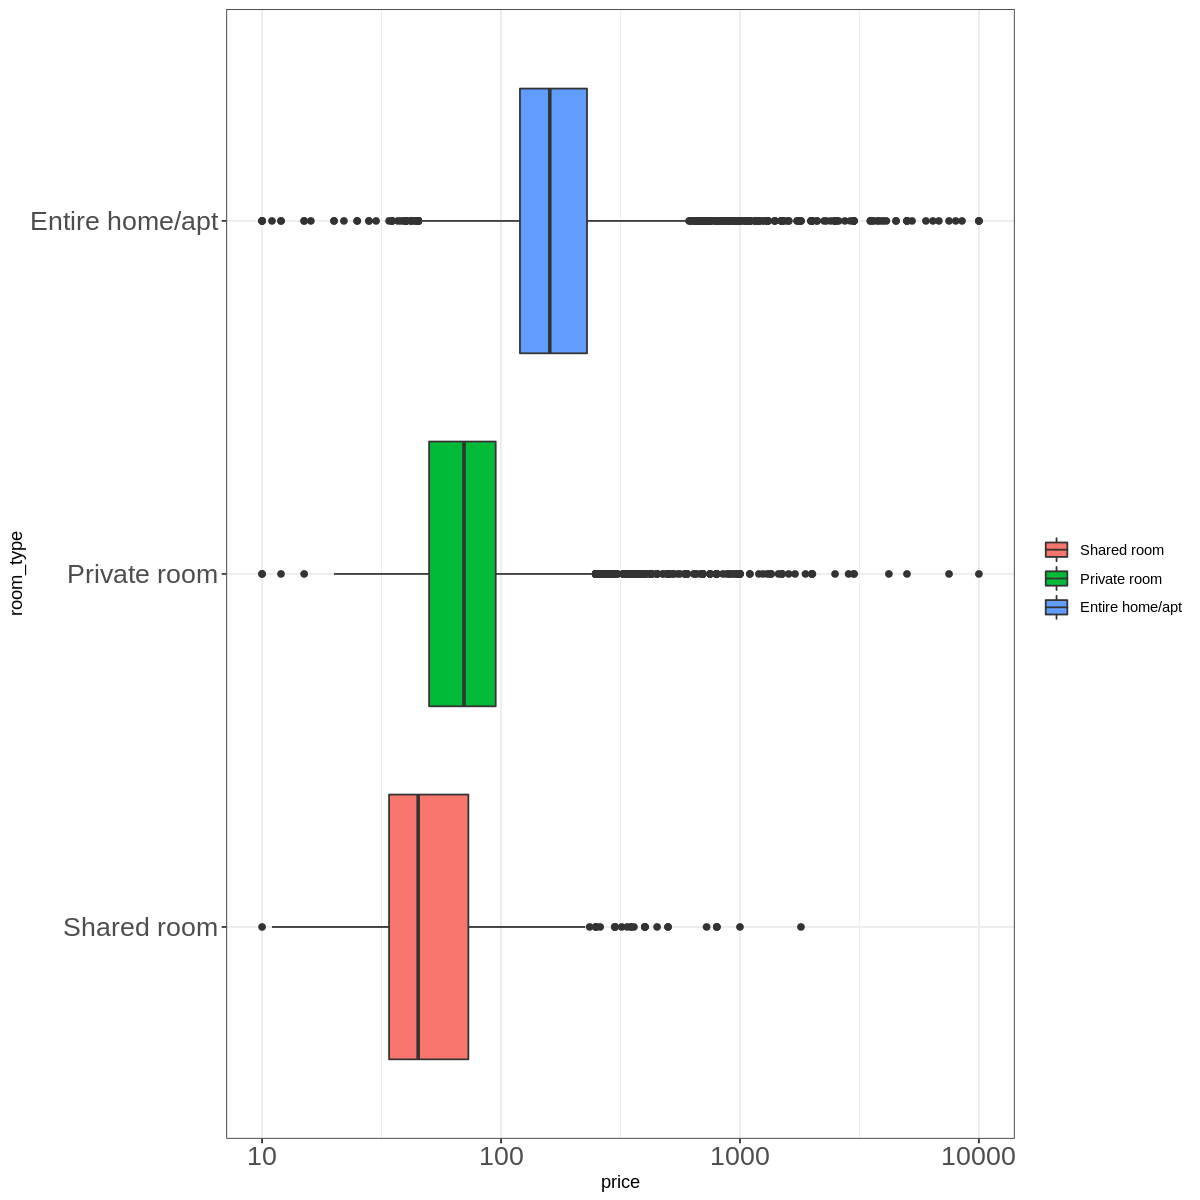

In [ ]:
## Room type
train_raw %>%
  mutate(room_type = fct_reorder(room_type, price)) %>%
  ggplot(aes(price, room_type, fill = room_type)) +
  geom_boxplot() + 
  scale_x_log10() + theme_bw() + labs(fill = NULL)+
  theme(axis.text = element_text(size=16))

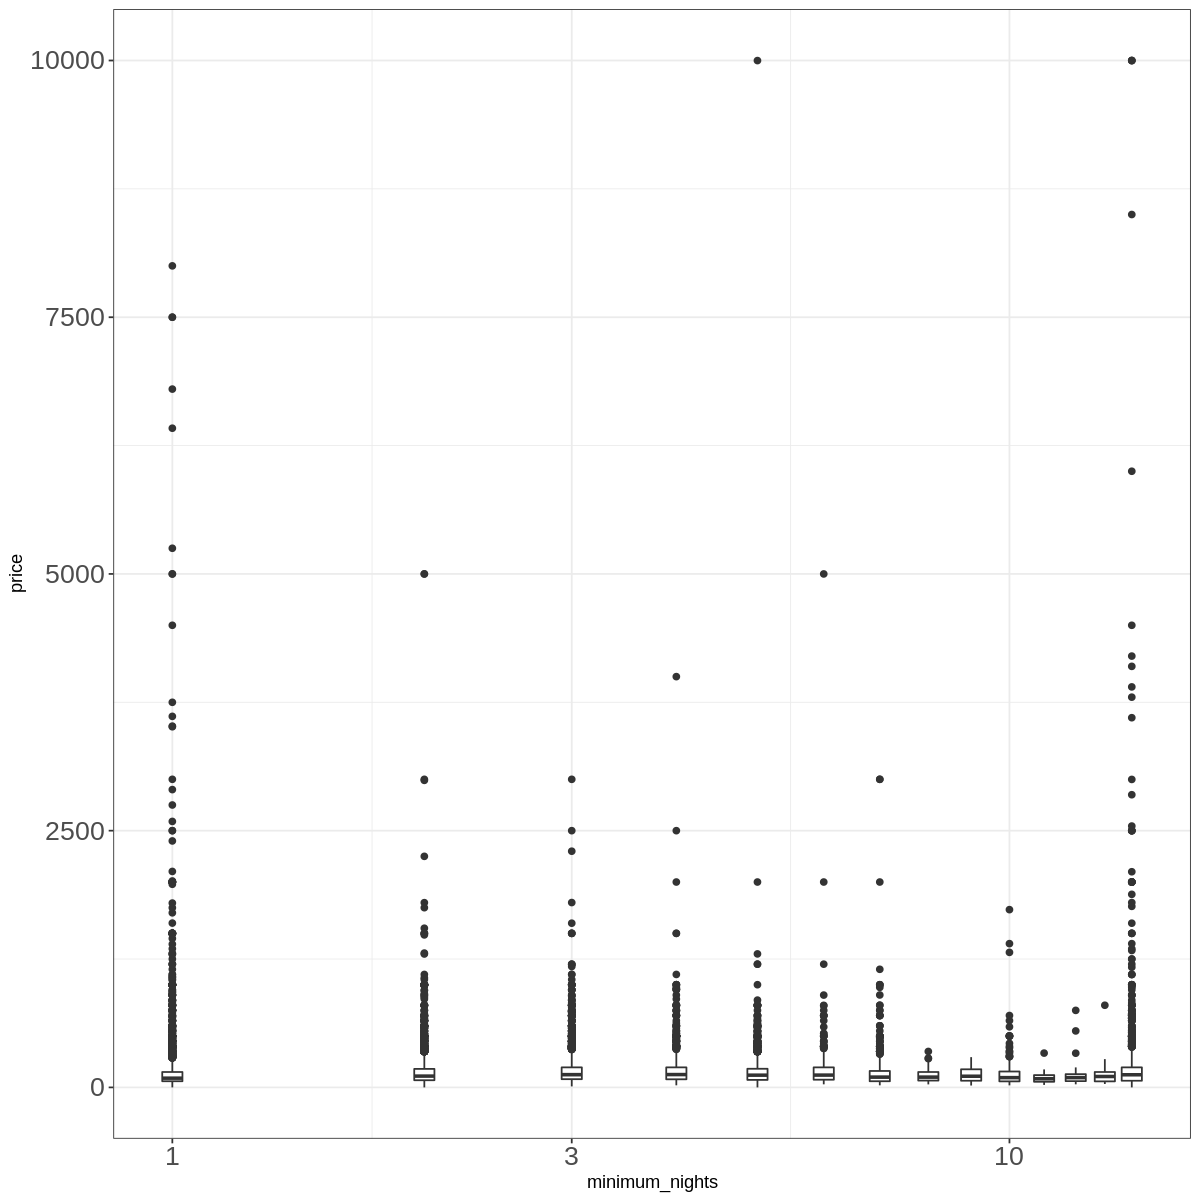

In [ ]:
## Minimum nights
train_raw %>%
  mutate(minimum_nights = pmin(minimum_nights, 14)) %>%
  ggplot(aes(minimum_nights, price, group = minimum_nights)) +
  geom_boxplot() +
  scale_x_log10() + theme_bw()+
  theme(axis.text = element_text(size=16))

It's a bit hard to see from this plot, we'll resample a few thousands to have a clearer exploration.

`geom_smooth()` using formula 'y ~ x'



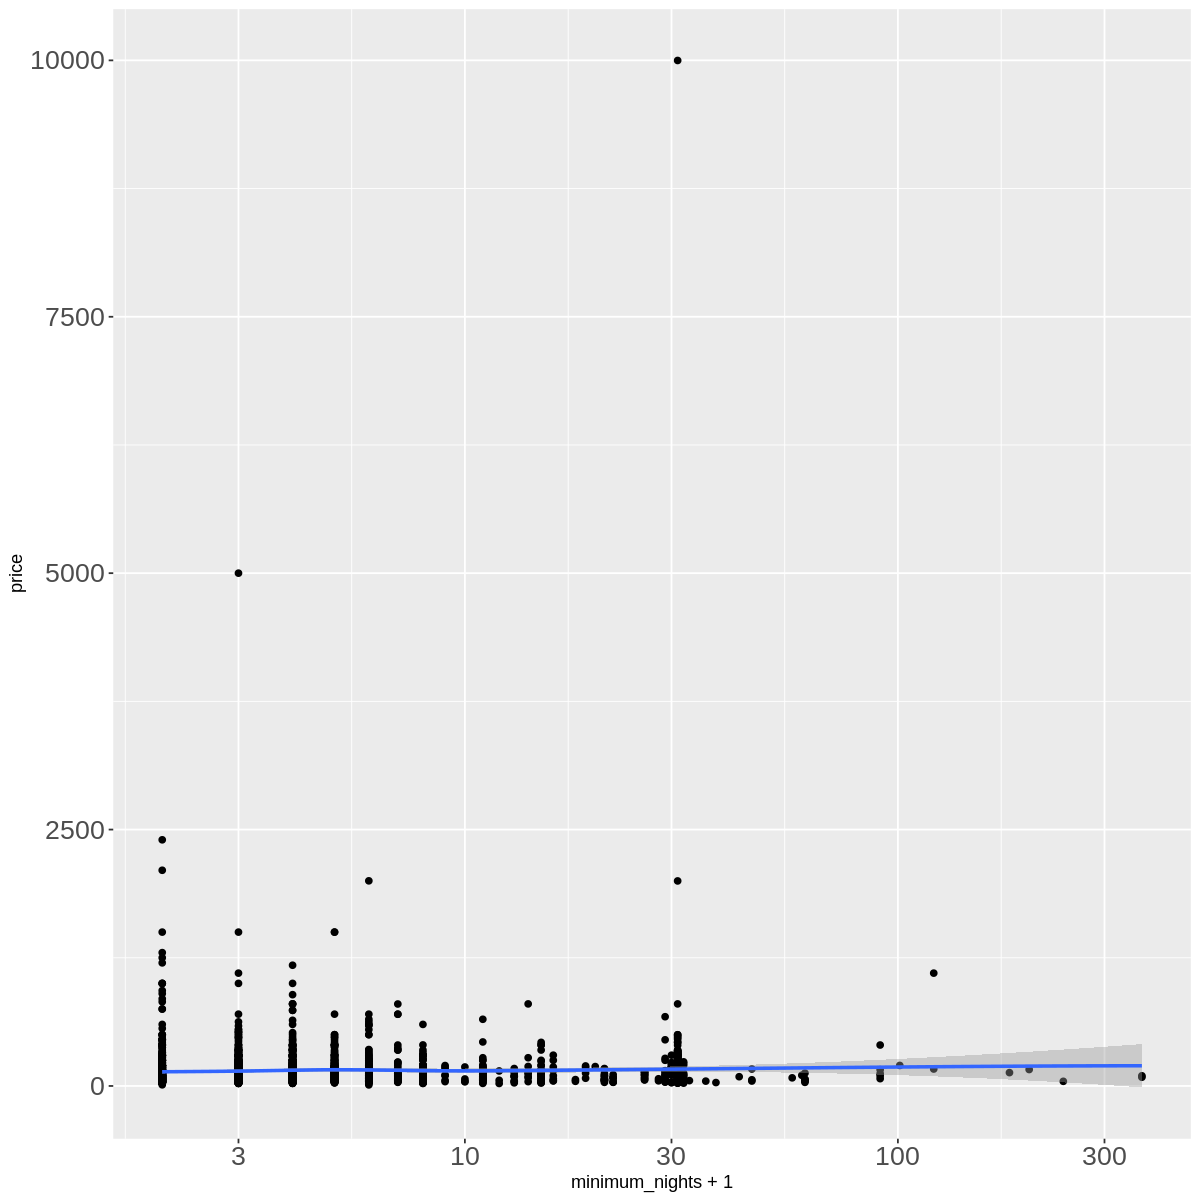

In [ ]:
train_raw %>%
  sample_n(3000) %>%
  ggplot(aes(minimum_nights + 1, price)) +
  geom_point() +
  scale_x_log10() +
  geom_smooth(method = "loess")+
  theme(axis.text = element_text(size=16))

The price seems steadily constant with increasing number of `minimum_nights`

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 7008 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 7008 rows containing missing values (geom_point).”


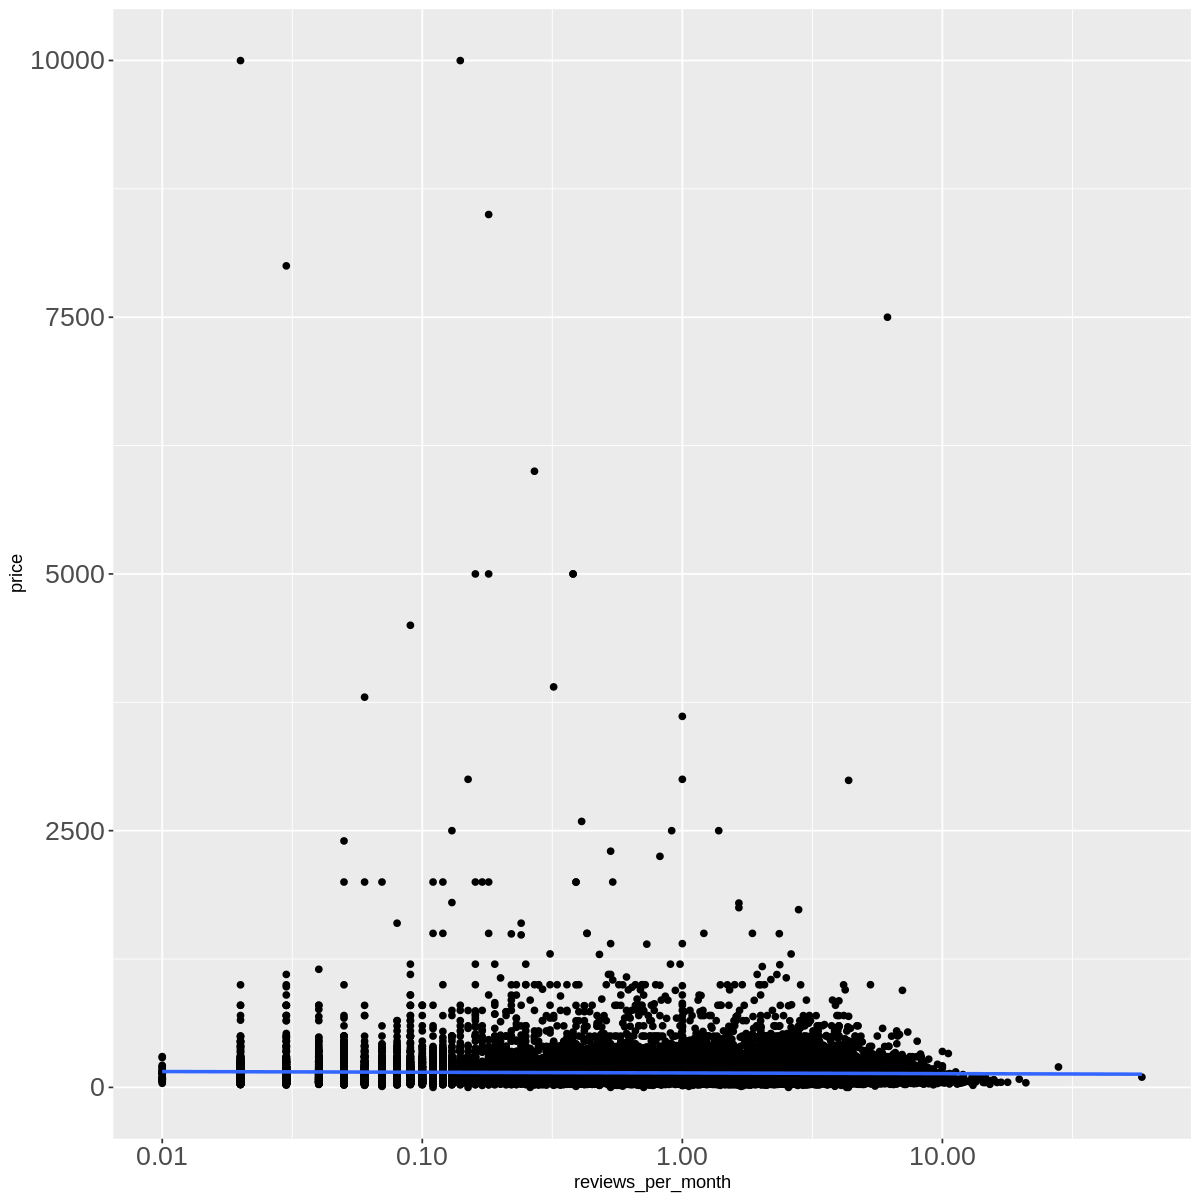

In [ ]:
## Reviews per month
train_raw %>%
  ggplot(aes(reviews_per_month, price)) +
  geom_point() +
  scale_x_log10() +
  geom_smooth(method = "lm")+
  theme(axis.text = element_text(size=16))

`geom_smooth()` using formula 'y ~ x'



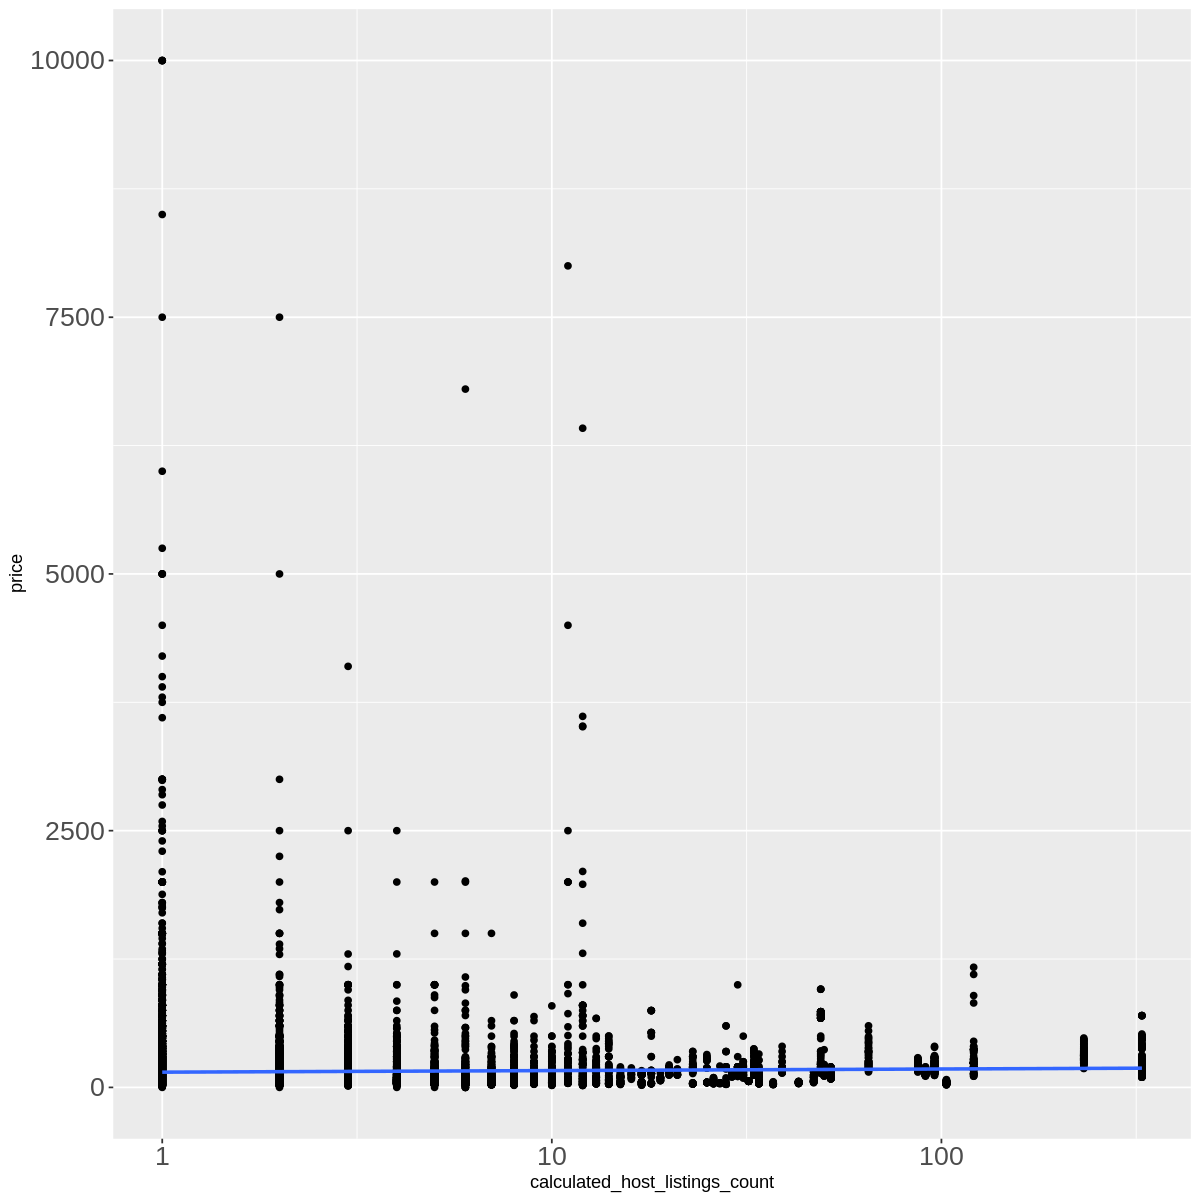

In [ ]:
## Calculated host listings count
train_raw %>%
  ggplot(aes(calculated_host_listings_count, price)) +
  geom_point() +
  scale_x_log10() +
  geom_smooth(method = "lm")+
  theme(axis.text = element_text(size=16))

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 12134 rows containing non-finite values (stat_smooth).”


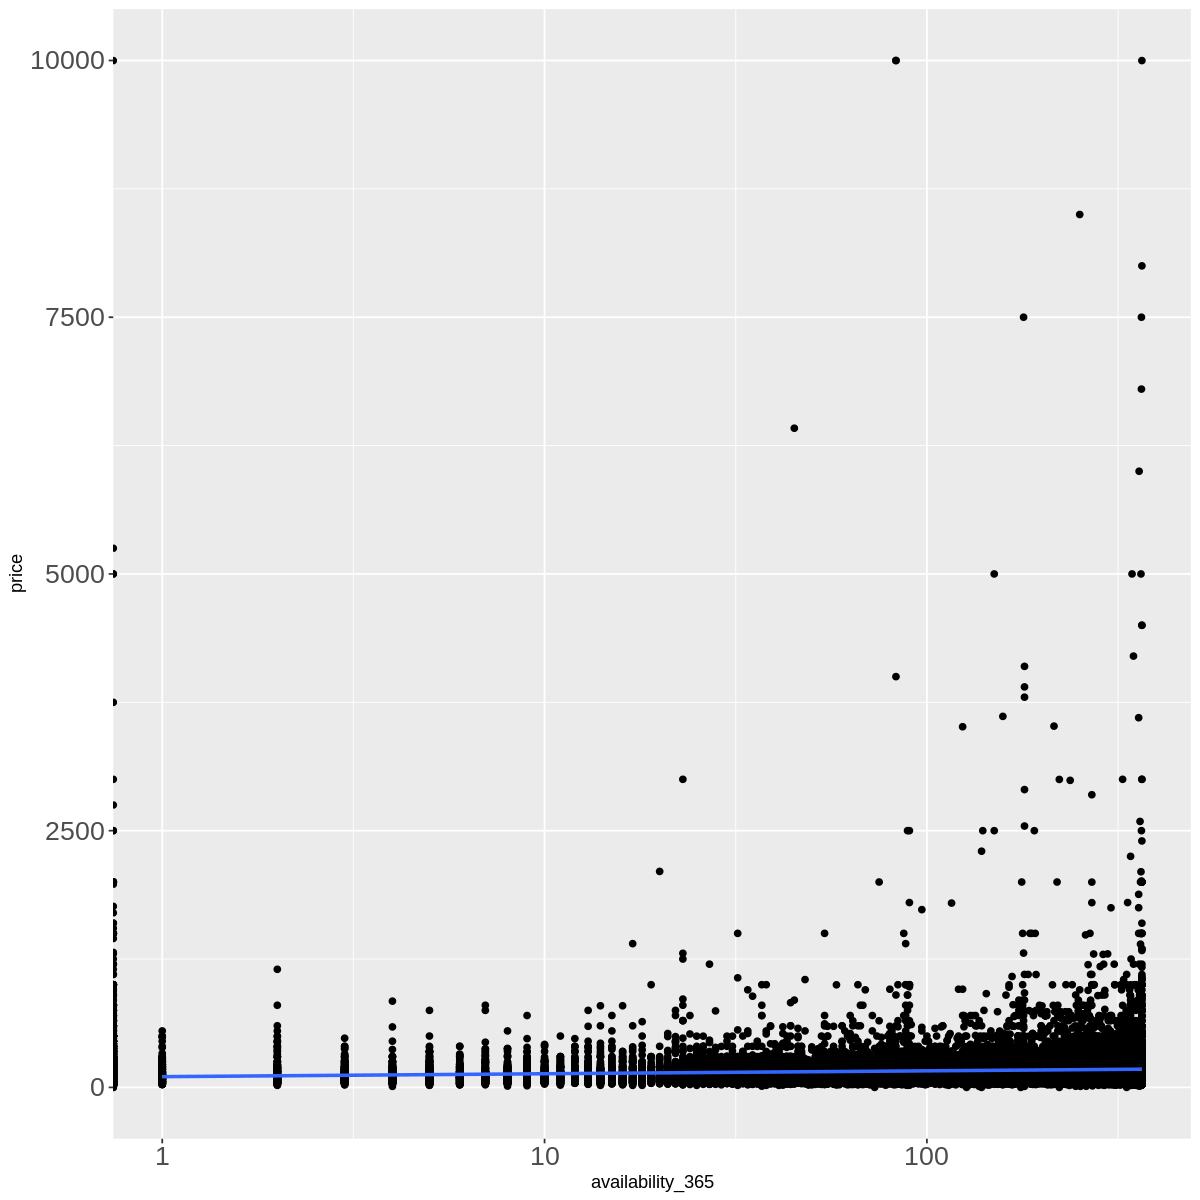

In [ ]:
train_raw %>%
  ggplot(aes(availability_365, price)) +
  geom_point() +
  scale_x_log10() +
  geom_smooth(method = "lm")+
  theme(axis.text = element_text(size=16))

## Text Analysis

There are a few columns with text which can be explored as important features as well.

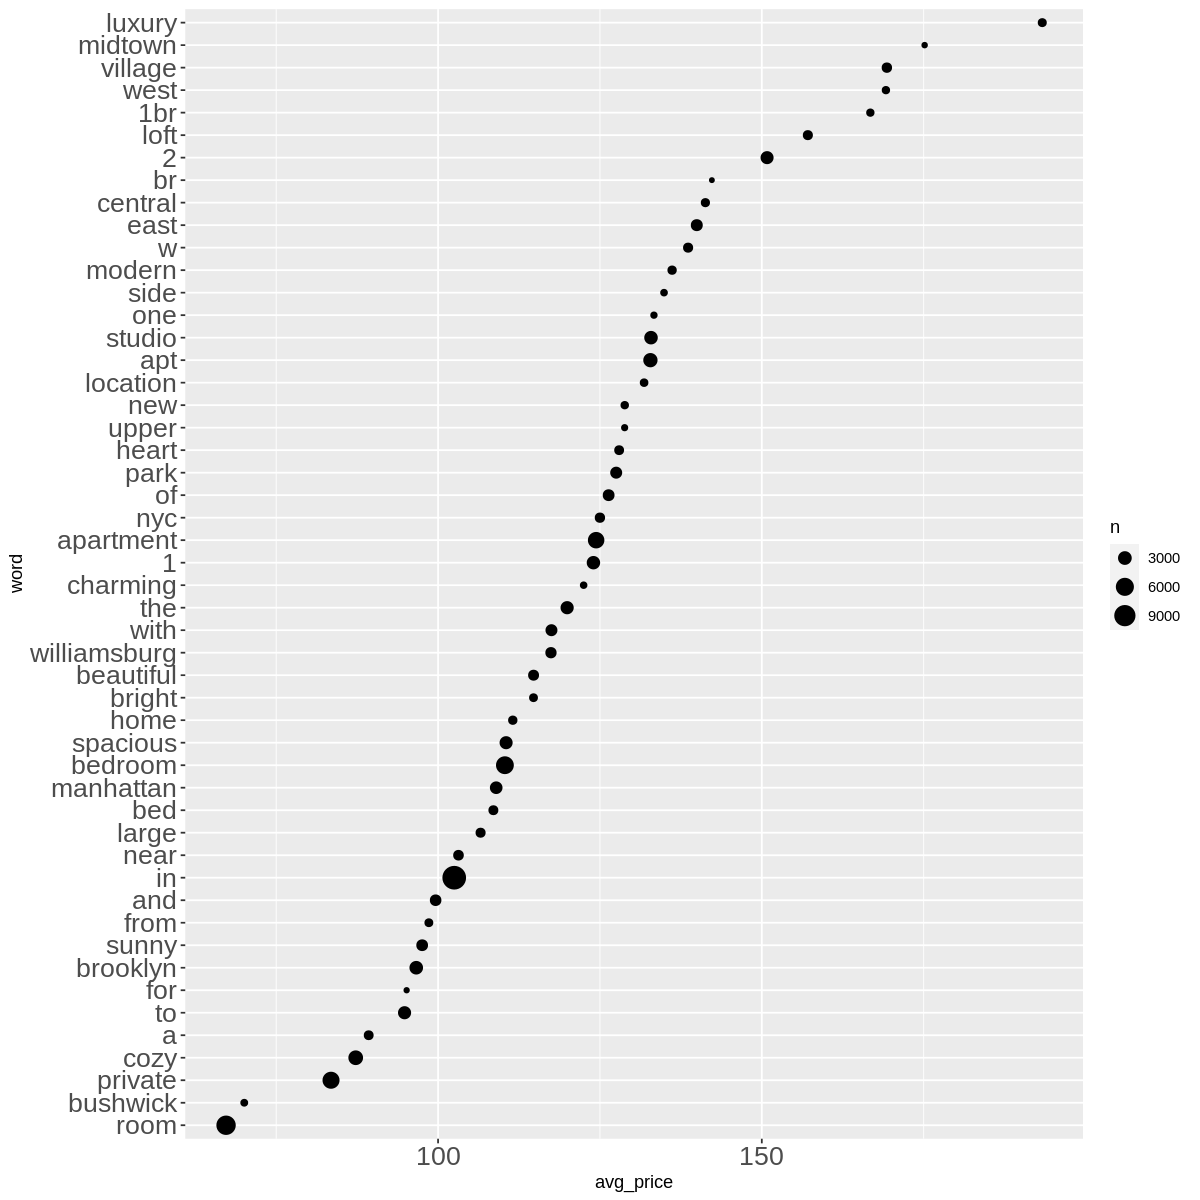

In [ ]:
library(tidytext)

train_raw %>%
  mutate(price = log(price + 1)) %>%
  unnest_tokens(word, name) %>%
  group_by(word) %>%
  summarize_prices() %>%
  head(50) %>%
  mutate(word = fct_reorder(word, avg_price)) %>%
  ggplot(aes(avg_price, word, size = n)) +
  geom_point()+
  theme(axis.text = element_text(size=16))

It's clear that certain words are related with higher prices.

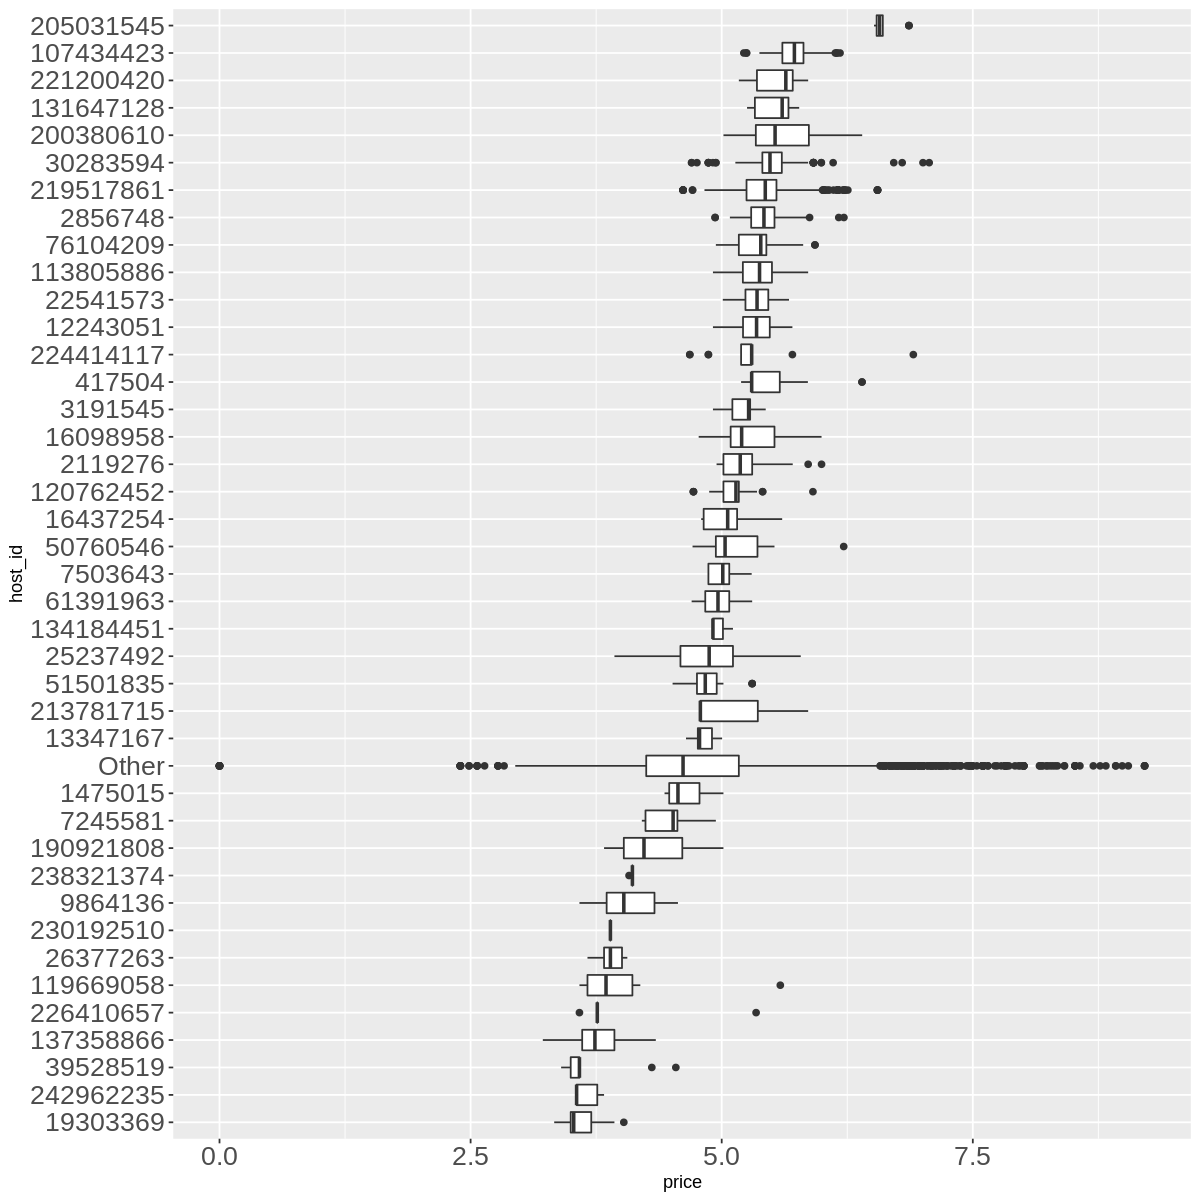

In [ ]:
train_raw %>%
  mutate(price = log(price + 1)) %>%
  mutate(host_id = factor(host_id)) %>%
  mutate(host_id = fct_lump(host_id, 40)) %>%
  mutate(host_id = fct_reorder(host_id, price)) %>%
  ggplot(aes(price, host_id)) +
  geom_boxplot()+
  theme(axis.text = element_text(size=16))

## Map analysis
Let's look the map distribution for price

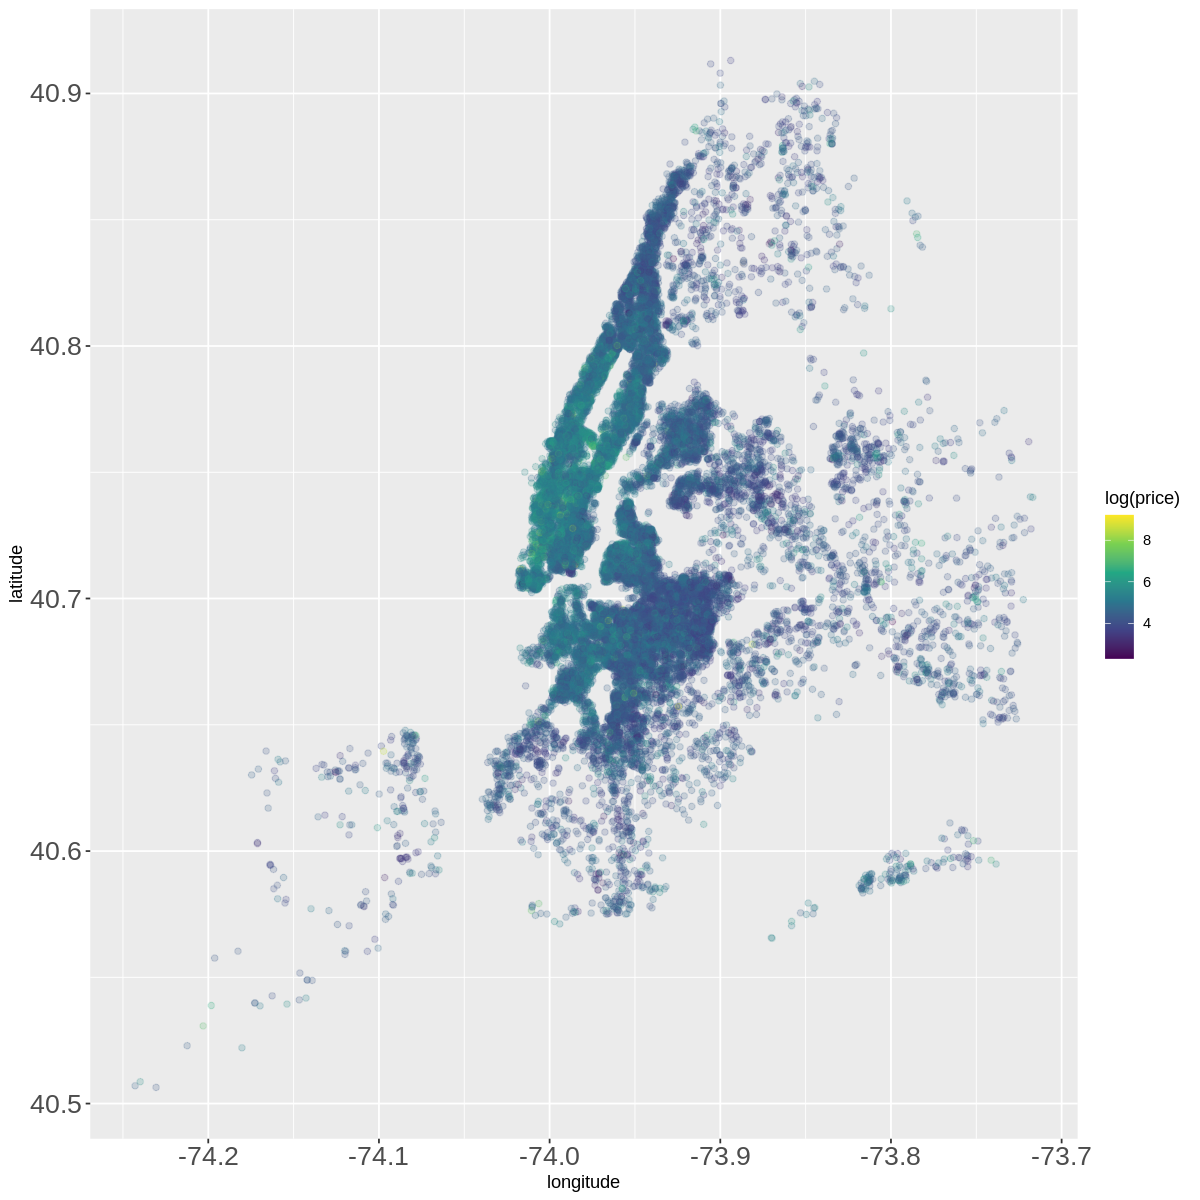

In [ ]:
train_raw %>% 
  ggplot(aes(longitude, latitude, color = log(price))) +
  geom_point(alpha = 0.2) + 
  scale_color_viridis_c()+
  theme(axis.text = element_text(size=16))

We can also use hex bins for the map to visualize the mean price in each area.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“Removed 8 rows containing non-finite values (stat_summary_hex).”


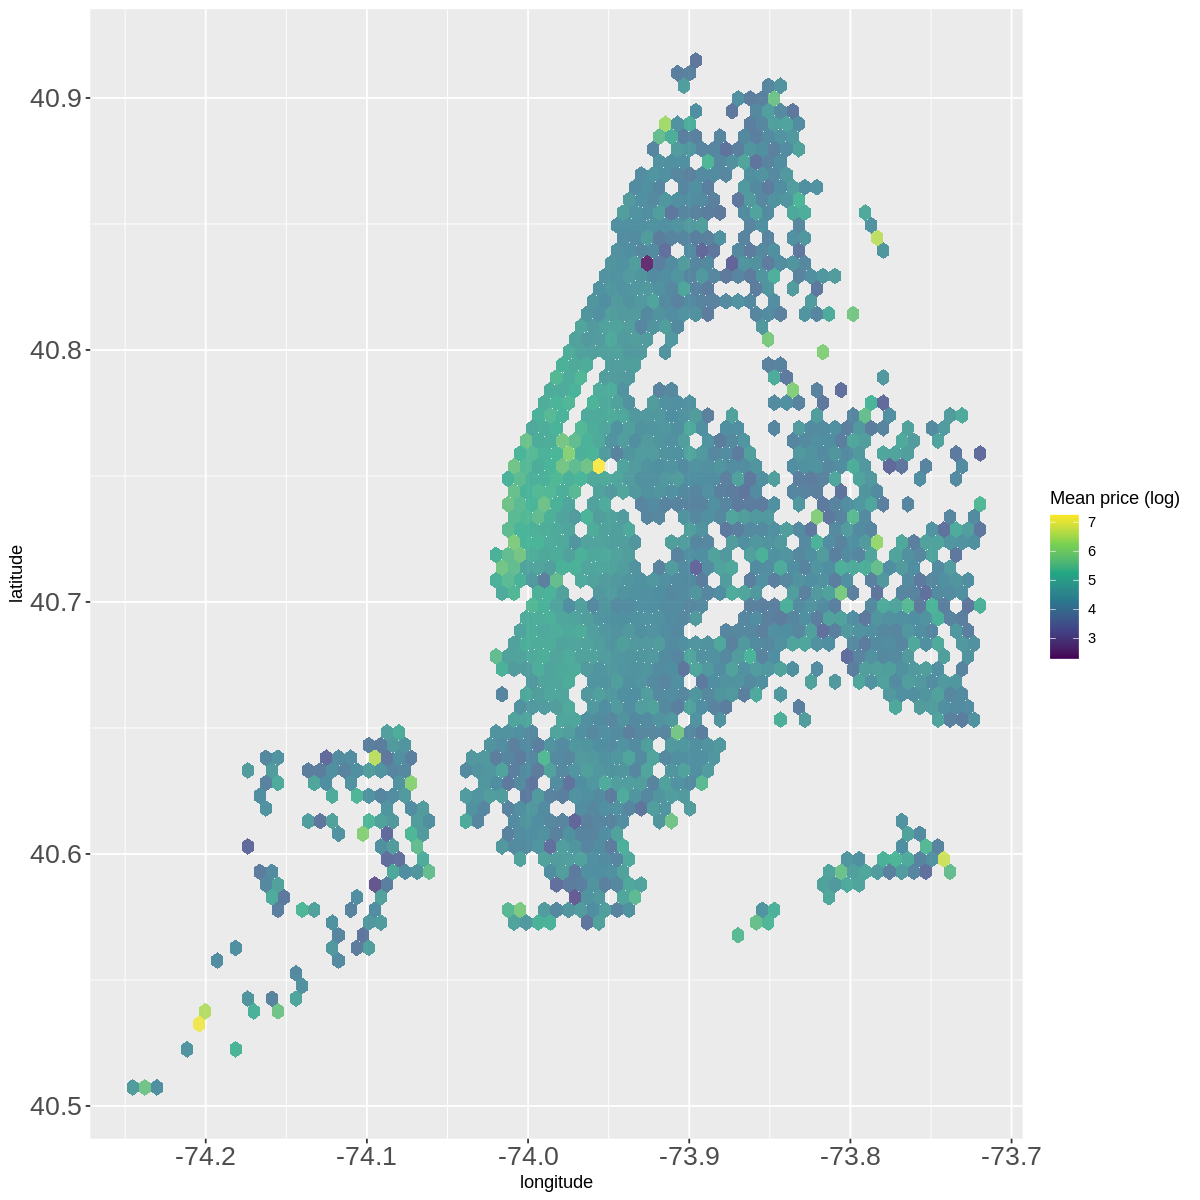

In [ ]:
install.packages('hexbin')
train_raw %>%
  ggplot(aes(longitude, latitude, z = log(price))) +
  stat_summary_hex(alpha = 0.8, bins = 70) +
  scale_fill_viridis_c() + 
  labs(fill = 'Mean price (log)')+
  theme(axis.text = element_text(size=16))

As commonly known, price is closely influenced by the geographical location.

In [ ]:
install.packages(c('ggthemes', 'ggmap'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



`summarise()` has grouped output by 'latitude'. You can override using the `.groups` argument.



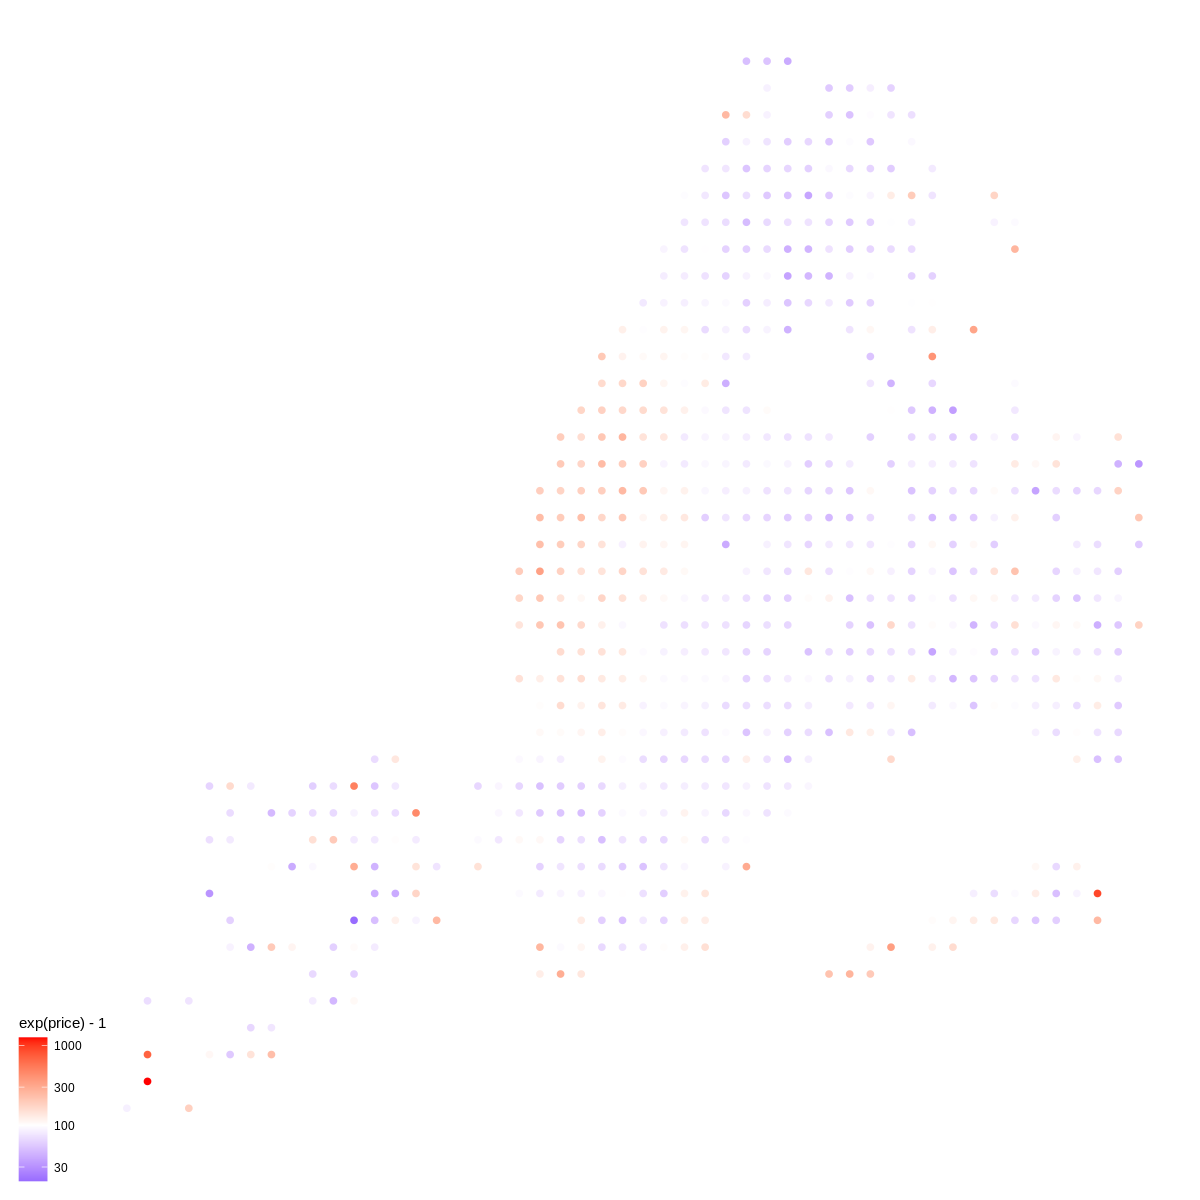

In [ ]:
library(ggthemes)
train_raw %>%
  mutate(price = log(price + 1)) %>%
  group_by(latitude = round(latitude, 2),
           longitude = round(longitude, 2)) %>%
  summarize(price = mean(price)) %>%
  ggplot(aes(longitude, latitude, color = exp(price) - 1)) +
  geom_point() +
  scale_color_gradient2(low = "blue", high = "red", midpoint = 2,
                        trans = "log10") +
  theme_map()

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.

Source : http://tile.stamen.com/terrain/11/601/768.png

Source : http://tile.stamen.com/terrain/11/602/768.png

Source : http://tile.stamen.com/terrain/11/603/768.png

Source : http://tile.stamen.com/terrain/11/604/768.png

Source : http://tile.stamen.com/terrain/11/601/769.png

Source : http://tile.stamen.com/terrain/11/602/769.png

Source : http://tile.stamen.com/terrain/11/603/769.png

Source : http://tile.stamen.com/terrain/11/604/769.png

Source : http://tile.stamen.com/terrain/11/601/770.png

Source : http://tile.stamen.com/terrain/11/602/770.png

Source : http://tile.stamen.com/terrain/11/603/770.png

Source : http://tile.stamen.com/terrain/11/604/770.png

Source : http://tile.stamen.com/terrain/11/601/771.png

Source : http://tile.stamen.com/terrain/11/602/771.png

Source : http://tile.stamen.com/terrain/11/603/771.png

Source : http://

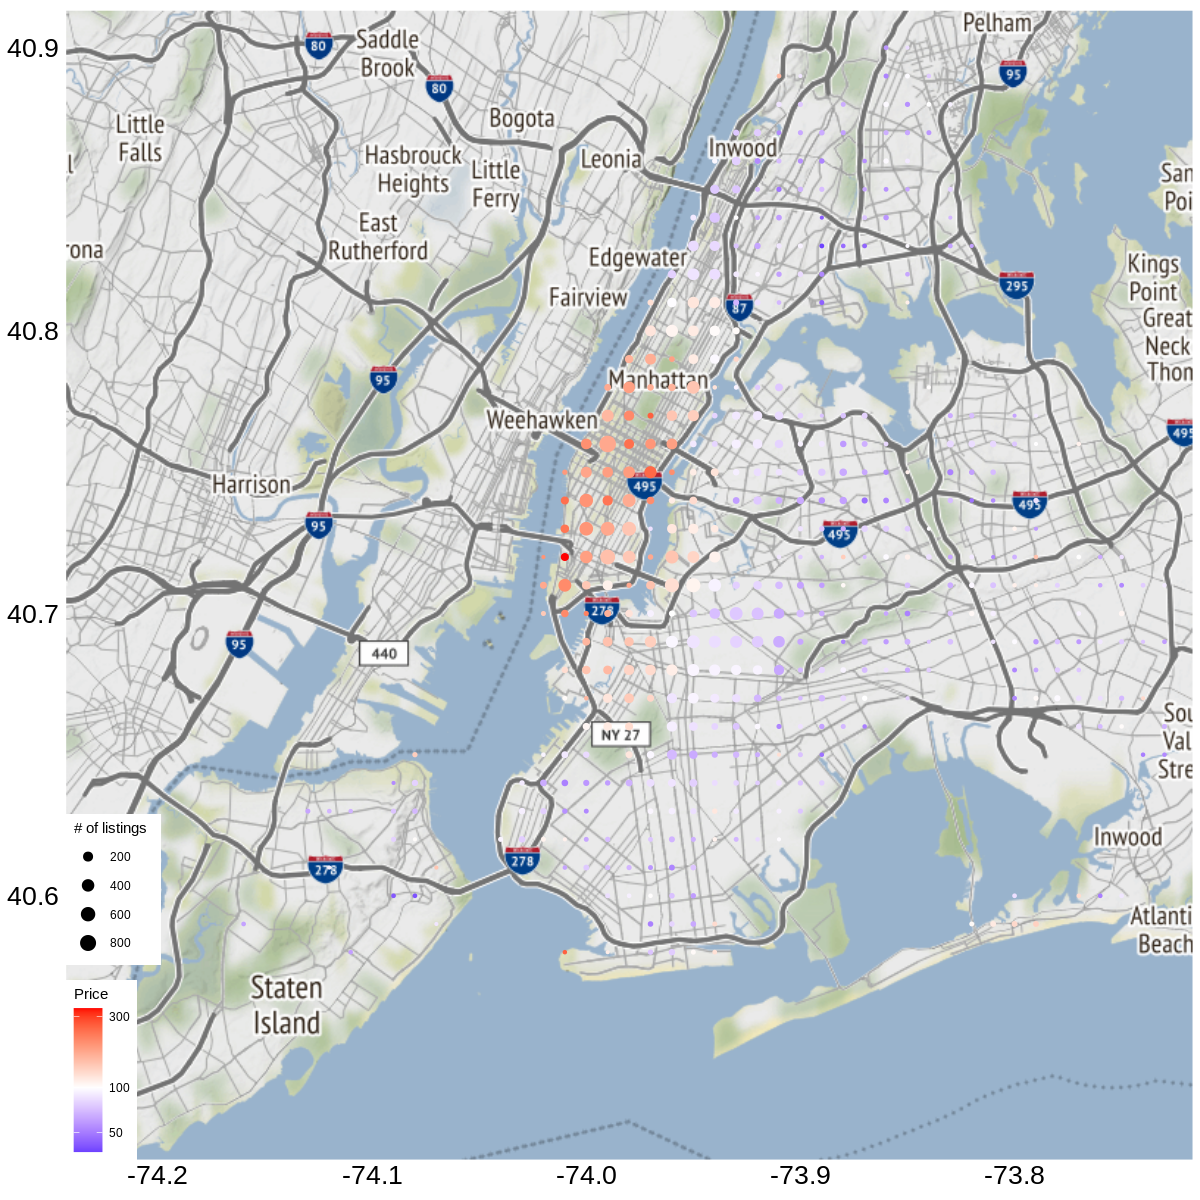

In [ ]:
library(ggmap)
bbox <- c(left = -74.24285, bottom = 40.50641, right = -73.71690, top = 40.91306)
nyc_map <- get_stamenmap(bbox, zoom = 11)

aggregated_lat_lon <- train_raw %>%
  mutate(price = log(price + 1)) %>%
  group_by(latitude = round(latitude, 2),
           longitude = round(longitude, 2)) %>%
  summarize(price = mean(price),
            n = n()) %>%        
  filter(n >= 5)

ggmap(nyc_map) +
  geom_point(aes(longitude, latitude, size = n, color = exp(price) - 1),
             data = aggregated_lat_lon) +
  scale_color_gradient2(low = "blue", high = "red", midpoint = 2,
                        trans = "log10") +
  scale_size_continuous(range = c(.5, 4)) +
  theme_map() +
  labs(color = "Price",
       size = "# of listings")+
  theme(axis.text = element_text(size=16))

## Build a model

In [ ]:
library(tidymodels)

set.seed(123)

nyc_split <- train_raw %>%
  mutate(price = log(price + 1)) %>%
  initial_split(strate = price)
nyc_train <- training(nyc_split)
nyc_test <- testing(nyc_split)

set.seed(234)
nyc_folds <- vfold_cv(nyc_train, v = 5, strata = price)
#nyc_folds

### Feature Engineering
We can handle the many levels in `neighborhood` and create features from the text in the `name` variable. For a quick start, we shall proceed with only top 30 tokens.

In [ ]:
library(textrecipes)
nyc_rec <-
  recipe(price ~ latitude + longitude + neighbourhood + room_type +
    minimum_nights + number_of_reviews + availability_365 + name,
  data = nyc_train
  ) %>%
  step_novel(neighbourhood) %>%
  step_other(neighbourhood, threshold = 0.01) %>%
  step_tokenize(name) %>%
  step_stopwords(name) %>%
  # create an indicator variable from the words in the `name`
  step_tokenfilter(name, max_tokens = 30) %>%
  step_tf(name)

nyc_rec

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          8

Operations:

Novel factor level assignment for neighbourhood
Collapsing factor levels for neighbourhood
Tokenization for name
Stop word removal for name
Text filtering for name
Term frequency with name

In [ ]:
install.packages('stopwords')
nyc_rec %>% prep() %>% bake(new_data = NULL)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ISOcodes’




latitude longitude neighbourhood             room_type      
1     40.63443 -74.07573 other                     Private room   
2     40.80564 -73.94198 East Harlem               Private room   
3     40.71962 -73.85000 other                     Private room   
4     40.65596 -73.95350 Prospect-Lefferts Gardens Private room   
5     40.71868 -73.95917 Williamsburg              Private room   
6     40.71317 -74.00654 other                     Entire home/apt
7     40.65026 -73.96316 Flatbush                  Private room   
8     40.76465 -73.98155 Midtown                   Private room   
9     40.73630 -74.00494 West Village              Entire home/apt
10    40.64456 -74.00839 other                     Private room   
11    40.73572 -73.98735 other                     Entire home/apt
12    40.83233 -73.94562 Harlem                    Private room   
13    40.70779 -74.01249 Financial District        Entire home/apt
14    40.74839 -73.88818 other                     Private room   
15    40.70080 -73.93940 Bushwick                  Shared room    
16    40.72289 -73.99431 other                     Entire home/apt
17    40.70041 -73.93957 Bushwick                  Entire home/apt
18    40.73711 -73.98573 other                     Entire home/apt
19    40.72168 -73.98686 Lower East Side           Entire home/apt
20    40.76311 -73.99388 Hell's Kitchen            Private room   
21    40.65500 -73.92764 East Flatbush             Private room   
22    40.80326 -73.93500 East Harlem               Entire home/apt
23    40.64553 -74.08323 other                     Entire home/apt
24    40.69654 -73.90034 Ridgewood                 Private room   
25    40.70426 -73.81509 other                     Private room   
26    40.70451 -74.00671 Financial District        Entire home/apt
27    40.73661 -73.98706 other                     Entire home/apt
28    40.80798 -73.96585 other                     Entire home/apt
29    40.68362 -73.99714 other                     Entire home/apt
30    40.73821 -73.81006 other                     Private room   
⋮     ⋮        ⋮         ⋮                         ⋮              
25640 40.70249 -73.91904 Bushwick                  Private room   
25641 40.72428 -73.98748 East Village              Entire home/apt
25642 40.80529 -73.94718 Harlem                    Entire home/apt
25643 40.66325 -73.94978 Prospect-Lefferts Gardens Entire home/apt
25644 40.66985 -73.95675 Crown Heights             Private room   
25645 40.70612 -73.90790 Ridgewood                 Entire home/apt
25646 40.70429 -73.98773 other                     Private room   
25647 40.78834 -73.97215 Upper West Side           Entire home/apt
25648 40.66913 -73.94028 Crown Heights             Entire home/apt
25649 40.80985 -73.94348 Harlem                    Private room   
25650 40.69604 -73.92278 Bushwick                  Private room   
25651 40.72396 -73.95182 Greenpoint                Private room   
25652 40.74163 -73.97533 other                     Entire home/apt
25653 40.72351 -73.94059 Greenpoint                Private room   
25654 40.71805 -73.93973 Williamsburg              Private room   
25655 40.71260 -73.93982 Williamsburg              Private room   
25656 40.69344 -73.96153 Clinton Hill              Private room   
25657 40.70660 -74.00396 Financial District        Private room   
25658 40.76370 -73.92380 Astoria                   Private room   
25659 40.67050 -73.87851 other                     Entire home/apt
25660 40.75426 -73.96886 Midtown                   Entire home/apt
25661 40.69054 -73.96063 Clinton Hill              Entire home/apt
25662 40.72823 -73.97967 East Village              Private room   
25663 40.72974 -73.98372 East Village              Entire home/apt
25664 40.68515 -73.93255 Bedford-Stuyvesant        Entire home/apt
25665 40.68635 -73.94821 Bedford-Stuyvesant        Private room   
25666 40.75094 -73.99748 Chelsea                   Private room   
25667 40.83488 -73.91988 other                     Pr

### Bagged Tree Model
Firstly, we can try a bagged tree model.

In [ ]:
library(baguette)

bag_spec <-
  bag_tree(min_n = 10) %>%
  set_engine('rpart', times = 25) %>%
  set_mode('regression')

bag_wf <-
  workflow() %>%
  add_recipe(nyc_rec) %>%
  add_model(bag_spec)

set.seed(123)
bag_fit <- fit(bag_wf, data = nyc_train)
bag_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: bag_tree()

── Preprocessor ────────────────────────────────────────────────────────────────
6 Recipe Steps

• step_novel()
• step_other()
• step_tokenize()
• step_stopwords()
• step_tokenfilter()
• step_tf()

── Model ───────────────────────────────────────────────────────────────────────
Bagged CART (regression with 25 members)

Variable importance scores include:

# A tibble: 37 × 4
   term              value std.error  used
   <chr>             <dbl>     <dbl> <int>
 1 room_type         4778.     18.3     25
 2 longitude         3046.     20.1     25
 3 neighbourhood     2551.     15.2     25
 4 tf_name_room      2022.      9.34    25
 5 latitude          1839.     13.8     25
 6 minimum_nights    1566.     10.9     25
 7 availability_365  1121.     10.7     25
 8 tf_name_private    958.      6.71    25
 9 number_of_reviews  913.      7.67    25
10 tf_name_studio     186.   

## Evaluate a model with a custom metric

We can evaluate the model using [resampling](https://www.tmwr.org/resampling.html)

In [ ]:
install.packages('doParallel')
doParallel::registerDoParallel()

# try default metric first
set.seed(123)
bag_rs <- fit_resamples(bag_wf, nyc_folds)
collect_metrics(bag_rs)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



.metric .estimator mean      n std_err     .config             
1 rmse    standard   0.4408449 5 0.003030700 Preprocessor1_Model1
2 rsq     standard   0.5977345 5 0.004610684 Preprocessor1_Model1

What we have now is RMSE on the log of price, not RMSLE on price

In [ ]:
test_rs <- augment(bag_fit, nyc_test)



Warning message:
“Ignoring unknown parameters: sty”


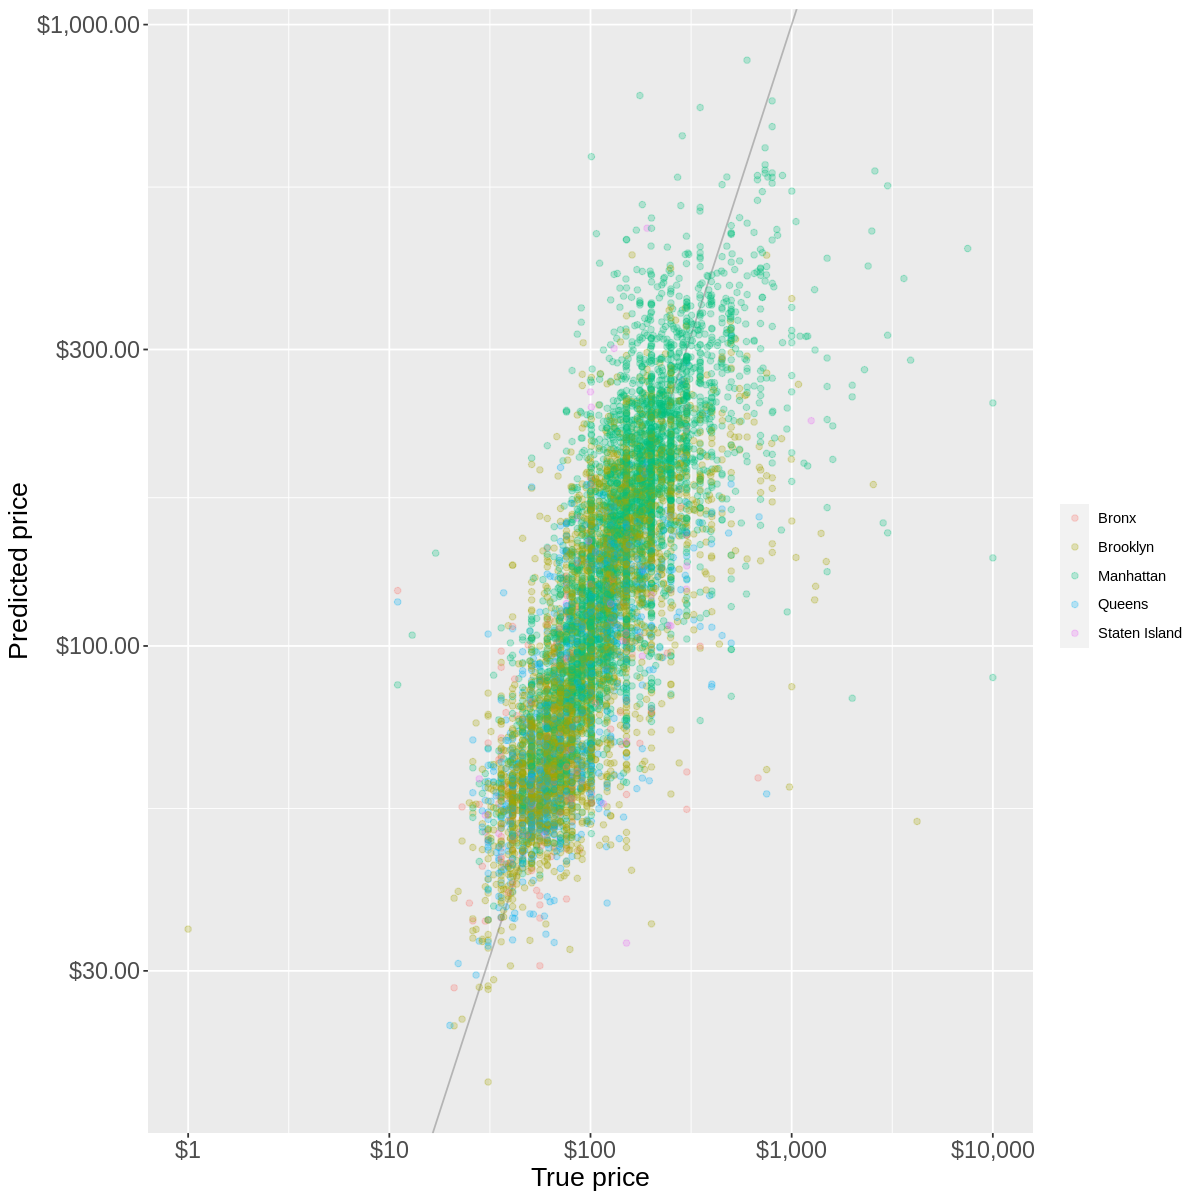

In [ ]:
test_rs %>%
  ggplot(aes(exp(price), exp(.pred), color = neighbourhood_group)) + 
  geom_abline(slope = 1, sty = 2, color = 'gray50', alpha = 0.5) + 
  geom_point(alpha = 0.25) + 
  scale_x_log10(labels = scales::dollar_format()) + 
  scale_y_log10(labels = scales::dollar_format()) + 
  labs(color = NULL, x = 'True price', y = 'Predicted price') +
  theme(axis.text = element_text(size = 14),
        axis.title = element_text(size = 16))

In [ ]:
library(rlang)



In [ ]:
# first compute the metric for a vector
print(rmse_vec)

# second make a method for a dataframe
print(metric_summarizer)

function (truth, estimate, na_rm = TRUE, ...) 
{
    rmse_impl <- function(truth, estimate) {
        sqrt(mean((truth - estimate)^2))
    }
    metric_vec_template(metric_impl = rmse_impl, truth = truth, 
        estimate = estimate, na_rm = na_rm, cls = "numeric")
}
<bytecode: 0x55efe5846900>
<environment: namespace:yardstick>
function (metric_nm, metric_fn, data, truth, estimate, estimator = NULL, 
    na_rm = TRUE, event_level = NULL, ..., metric_fn_options = list()) 
{
    truth <- enquo(truth)
    estimate <- enquo(estimate)
    validate_not_missing(truth, "truth")
    validate_not_missing(estimate, "estimate")
    nms <- colnames(data)
    truth <- handle_chr_names(truth, nms)
    estimate <- handle_chr_names(estimate, nms)
    finalize_estimator_expr <- rlang::expr(finalize_estimator(!!truth, 
        estimator, metric_nm))
    metric_tbl <- dplyr::summarise(data, .metric = metric_nm, 
        .estimator = eval_tidy(finalize_estimator_expr), .estimate = metric_fn(truth = !!trut

In [ ]:
rmsle_vec <- function(truth, estimate, na_rm = TRUE, ...) {
  rmsle_impl <- function(truth, estimate) {
    sqrt(mean((log(truth + 1) - log(estimate + 1))^2))
  }

  metric_vec_template(
    metric_impl = rmsle_impl,
    truth = truth,
    estimate = estimate,
    na_rm = na_rm,
    cls = "numeric",
    ...
  )
}

rmsle <- function(data, ...) {
  UseMethod("rmsle")
}
rmsle <- new_numeric_metric(rmsle, direction = "minimize")

rmsle.data.frame <- function(data, truth, estimate, na_rm = TRUE, ...) {
  metric_summarizer(
    metric_nm = "rmsle",
    metric_fn = rmsle_vec,
    data = data,
    truth = !!enquo(truth),
    estimate = !!enquo(estimate),
    na_rm = na_rm,
    ...
  )
}

In [ ]:
metric_set(rmsle, mape)

# A tibble: 2 × 3
  metric class          direction
  <chr>  <chr>          <chr>    
1 rmsle  numeric_metric minimize 
2 mape   numeric_metric minimize

In [ ]:
test_rs %>%
  rmse(price, .pred)

.metric .estimator .estimate
1 rmse    standard   0.4293999

In [ ]:
test_rs %>%
  mutate(across(c(price, .pred), exp)) %>%
  rmsle(price, .pred)

.metric .estimator .estimate
1 rmsle   standard   0.4253865

### XGBoost

In [ ]:
predict_test <- function(wf) {
  wf %>%
    augment(test) %>%
    mutate(.pred = exp(.pred) - 1) %>%
    select(id, price = .pred)
}
augment.model_stack <- function(x, data, ...) {
  bind_cols(data, predict(x, data, ...))
}

In [ ]:
mset <- metric_set(rmse)

grid_control <- control_grid(save_pred = TRUE,
                            save_workflow = TRUE,
                            extract = extract_model)
                            

In [ ]:
prep_juice <- function(d) juice(prep(d))

# Doesn't include name, host_id, host_name, neighbourhood

xg_rec <- recipe(price ~ minimum_nights + room_type, number_of_reviews +
                  latitude + longitude + neighbourhood_group +
                  reviews_per_month + calculated_host_listings_count +
                  availability_365 + last_review,
                data = train_raw) %>%
          # step_log(all_numeric_predictors(), offset = 1) %>%
          step_mutate(is_manhattan = neighbourhood_group == 'Manhattan') %>%
          step_rm(neighbourhood_group) %>%
          step_mutate(last_review = coalesce(as.integer(Sys.Date() - last_review), 0)) %>%
          step_dummy(all_nominal_predictors())

In [ ]:
xg_mod <- boost_tree('regression',
                      mtry = tune(),
                      trees = tune(),
                      learn_rate = tune()) %>%
        set_engine('xgboost')

In [ ]:
xg_wf <- workflow() %>%
          add_recipe(xg_rec) %>%
          add_model(xg_mod)

In [ ]:
install.packages('xgboost')
xg_tune <- xg_wf %>%
    tune_grid(nyc_folds,
              metrics = mset,
              control = grid_control,
              grid = crossing(mtry = c(7),
                              trees = seq(250, 1500, 25),
                              learn_rate = c(.008, .01)))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
autoplot(xg_tune)

In [ ]:
xg_tune %>%
  collect_metrics() %>%
  arrange(mean)

In [ ]:
# Finalize version w/o categorical
xg_fit <- xg_wf %>%
  finalize_workflow(select_best(xg_tune)) %>%
  fit(train)

xg_fit %>%
  augment(test) %>%
  rmse(price, .pred)

importances <- xgboost::xgb.importance(model = xg_fit$fit$fit$fit)

importances %>%
  mutate(Feature = fct_reorder(Feature, Gain)) %>%
  ggplot(aes(Gain, Feature)) +
  geom_col()

xg_fit %>%
  predict_holdout() %>%
  write_csv("attempt1.csv")

* .535 with minimal version
* .468 once we add lat/lng and neighborhood group
* .444 once we add numeric variables like reviews per month

In [ ]:
xg_rec %>%
  prep_juice() %>%
  ggplot(aes(last_review)) +
  geom_histogram()

### Linear version on the categorical

In [ ]:
install.packages('glmnet')

In [ ]:
1 + 2